# Create plots
This notebook as the name suggests, creates potential plots to be used in the paper! Once we decided on the plots we like, I'll create separate python functions for the repo.


In [1]:
import glob
import pandas as pd
import os
import numpy as np
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import PercentFormatter

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-anu7fnxy because the default path (/ifs/home/jls106_gp/nhw2114/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


# 20240316_run
This is the latest (and hopefully last run) of simulations and performance metrics.

In [2]:
in_dir = "/ifs/scratch/jls106_gp/nhw2114/data/20240316_run/"
epiestim_in_dir = "/ifs/scratch/jls106_gp/nhw2114/data/20240731_epiestim_run_kl_w2_day"

eakf_metrics_df = pd.read_csv(in_dir + 'eakf_metrics_all.csv')
epiestim_metrics_df = pd.read_csv(in_dir + 'epiEstim_metrics_all.csv')


In [3]:
eakf_metrics_df.head()

,method,rt_rmse_up_to_last_epi_day,rt_rmse_last_epi_day,avg_w2_up_to_last_epi_day,avg_w2_last_epi_day,avg_kl_up_to_last_epi_day,avg_kl_last_epi_day,in_ci_last_epi_day,crps_last_epi_day,rt_rmse_up_to_first_epi_day,rt_rmse_first_epi_day,avg_w2_up_to_first_epi_day,avg_w2_first_epi_day,avg_kl_up_to_first_epi_day,avg_kl_first_epi_day,in_ci_first_epi_day,crps_first_epi_day,param
0,adaptive inflation,0.346837,0.208923,0.752354,0.113138,0.980524,0.106043,0.76,0.169398,0.372755,0.378227,0.718416,0.718675,0.976584,0.960194,1.0,1.194547,46482
1,fixed inflation,0.470807,0.281239,1.108278,0.148160,5.544861,0.148249,0.04,0.231532,0.324684,0.462354,0.851867,1.106781,1.606580,3.991537,0.0,1.554124,46482
2,no inflation,1.236706,2.529351,1.298766,0.537245,9.201152,6.102437,0.00,0.410941,0.297479,0.439387,1.029738,1.166657,2.743090,3.651745,0.0,1.580393,46482
3,smooth inflation,0.163637,0.209092,0.353428,0.140692,0.805754,0.760793,0.77,0.231259,0.101859,0.349259,0.374711,0.279258,0.999070,0.116600,0.0,66.876930,46482
4,adaptive inflation,0.359455,0.136021,0.585877,0.074515,0.639868,0.063979,0.98,0.430353,0.343887,0.564527,0.603899,0.086624,0.698570,0.071173,1.0,0.513759,55685


## Table 2 and 3
This section prints out LaTeX code that can be copied into the overleaf file for tables 2 and 3.

In [4]:
def compute_ci(df, by_col):
    
    mean_df = df.groupby(by_col).mean()
    median_df = df.groupby(by_col).median()
    std_df = df.groupby(by_col).std()
    n_df = df.groupby(by_col).count()

    lower_df = df.groupby(by_col).quantile(q=0.025)
    upper_df = df.groupby(by_col).quantile(q=0.975)
    
    # add suffixes
    lower_df = lower_df.add_suffix('_lower')
    upper_df = upper_df.add_suffix('_upper')
    mean_df = mean_df.add_suffix('_mean')
    median_df = median_df.add_suffix('_median')
    # merge
    merge_df = lower_df.merge(mean_df, on=by_col)
    merge_df = merge_df.merge(upper_df, on=by_col)
    merge_df = merge_df.merge(median_df, on=by_col)
    
    return merge_df

def dataframe_to_latex(df, columns, titles, metric_dict=None, degree=2):
    """
    Convert a Pandas DataFrame with mean, lower, and upper columns to a LaTeX table.

    Parameters:
    - df: Pandas DataFrame.
    - columns: Columns of table.

    Returns:
    - LaTeX table string.
    """
    df = df[list(titles.keys())]
    # Column row
    tab_arg = "l|" * len(columns)
    latex_table = "\ begin{tabular}{|" + tab_arg + "} \hline "
    latex_table += " & ".join([titles[col] for col in df.columns])
    latex_table += " \\\\\n \hline "
    # Data rows
    for metric, title in metric_dict.items():
        latex_table += f"{title} & "
        
        mean = df.loc[df.metric == metric + "_mean"].round(degree).values.tolist()[0]
        lower = df.loc[df.metric == metric + "_lower"].round(degree).values.tolist()[0]
        upper = df.loc[df.metric == metric + "_upper"].round(degree).values.tolist()[0]
        median = df.loc[df.metric == metric + "_median"].round(degree).values.tolist()[0]
        latex_table += " &  ".join(
            [f"{mean[i]} ({lower[i]}, {upper[i]}) " for i in range(1,len(mean))]
        )
        latex_table += " \\\\\n \hline "
    
    latex_table += "\end{tabular}"

    return latex_table

In [5]:
# epiestim_metrics_df.drop(['colname.x', 'colname.y'], axis=1, inplace=True)
eakf_stats_df = compute_ci(eakf_metrics_df, "method")
epiestim_stats_df = compute_ci(epiestim_metrics_df, "window")

In [6]:
cols_for_table1 = ['metric', 'adaptive inflation', 'fixed inflation', 'no inflation', 'smooth inflation', 8]

metric_title_dict = {
    'in_ci_last_epi_day' : 'True $R_t$ within 95\% CI',
    'rt_rmse_last_epi_day' : '$R_t$ RMSE',
    'avg_w2_last_epi_day' : '$W_2(p,q)$',
    'avg_kl_last_epi_day' : '$D_{KL}(p || q)$',
    'crps_last_epi_day' : 'CRPS',
}
metric_title_first_dict = {
    'in_ci_first_epi_day' : 'True $R_t$ within 95\% CI',
    'rt_rmse_first_epi_day' : '$R_t$ RMSE',
    'avg_w2_first_epi_day' : '$W_2(p,q)$',
    'avg_kl_first_epi_day' : '$D_{KL}(p || q)$',
    'crps_first_epi_day' : 'CRPS',
}
col_title_dict = {
    'metric' : 'Metric',
    'no inflation' : 'no inflation',
    'fixed inflation' : 'fixed inflation',
    'adaptive inflation' : 'adaptive inflation',
    'smooth inflation' : 'EnSRS adaptive inflation', 
    8 : 'EpiEstim',
}
transpose_df = eakf_stats_df.T.reset_index().rename(columns={'index':'metric'})
epi_transpose_df = epiestim_stats_df[epiestim_stats_df.index == 8].T.reset_index().rename(columns={'index':'metric'})
transpose_df = transpose_df.merge(epi_transpose_df, on="metric")
print(dataframe_to_latex(transpose_df, cols_for_table1, col_title_dict, metric_title_dict))

\ begin{tabular}{|l|l|l|l|l|l|} \hline Metric & no inflation & fixed inflation & adaptive inflation & EnSRS adaptive inflation & EpiEstim \\
 \hline True $R_t$ within 95\% CI & 0.0 (0.0, 0.0)  &  0.43 (0.0, 1.0)  &  0.83 (0.0, 1.0)  &  0.83 (0.0, 1.0)  &  0.84 (0.0, 1.0)  \\
 \hline $R_t$ RMSE & 2.56 (1.1, 3.62)  &  0.62 (0.07, 2.8)  &  0.26 (0.08, 1.07)  &  0.26 (0.08, 1.07)  &  1.78 (0.79, 3.46)  \\
 \hline $W_2(p,q)$ & 0.39 (0.01, 0.94)  &  0.47 (0.02, 1.85)  &  0.16 (0.02, 0.56)  &  0.22 (0.01, 0.77)  &  0.28 (0.01, 0.81)  \\
 \hline $D_{KL}(p || q)$ & 4.06 (0.11, 12.83)  &  1.15 (0.04, 7.55)  &  0.3 (0.03, 2.0)  &  1.02 (0.05, 6.44)  &  1.48 (0.04, 7.79)  \\
 \hline CRPS & 0.83 (0.27, 1.9)  &  0.67 (0.19, 1.66)  &  0.53 (0.14, 1.27)  &  0.7 (0.22, 1.99)  &  5.87 (3.95, 7.54)  \\
 \hline \end{tabular}


In [7]:
print(dataframe_to_latex(transpose_df, cols_for_table1, col_title_dict, metric_title_first_dict))

\ begin{tabular}{|l|l|l|l|l|l|} \hline Metric & no inflation & fixed inflation & adaptive inflation & EnSRS adaptive inflation & EpiEstim \\
 \hline True $R_t$ within 95\% CI & 0.0 (0.0, 0.0)  &  0.37 (0.0, 1.0)  &  0.78 (0.0, 1.0)  &  0.51 (0.0, 1.0)  &  0.31 (0.0, 1.0)  \\
 \hline $R_t$ RMSE & 0.44 (0.2, 0.99)  &  0.48 (0.21, 0.99)  &  0.55 (0.16, 1.53)  &  0.38 (0.05, 1.03)  &  0.78 (0.11, 2.18)  \\
 \hline $W_2(p,q)$ & 0.72 (0.18, 1.51)  &  0.61 (0.07, 1.35)  &  0.39 (0.04, 1.13)  &  0.33 (0.07, 0.78)  &  1.09 (0.19, 1.88)  \\
 \hline $D_{KL}(p || q)$ & 2.0 (0.2, 10.32)  &  1.29 (0.06, 6.02)  &  0.56 (0.03, 2.64)  &  0.3 (0.05, 1.04)  &  6.25 (0.1, 22.55)  \\
 \hline CRPS & 5.51 (0.13, 35.54)  &  5.34 (0.11, 37.59)  &  4.2 (0.09, 31.83)  &  29.36 (0.39, 115.51)  &  47.16 (0.62, 263.81)  \\
 \hline \end{tabular}


In [8]:
transpose_df.loc[transpose_df.metric.isin([k + '_mean' for k in list(metric_title_first_dict.keys())])]

,metric,adaptive inflation,fixed inflation,no inflation,smooth inflation,8
26,rt_rmse_first_epi_day_mean,0.547531,0.480939,0.444331,0.379630,0.779492
28,avg_w2_first_epi_day_mean,0.388899,0.610557,0.718550,0.330305,1.088273
30,avg_kl_first_epi_day_mean,0.562223,1.285810,1.997526,0.296407,6.250043
31,in_ci_first_epi_day_mean,0.779713,0.367985,0.000000,0.513201,0.306156
32,crps_first_epi_day_mean,4.200745,5.337257,5.512691,29.363174,47.155433


In [9]:
transpose_df.loc[transpose_df.metric.isin([k + '_mean' for k in list(metric_title_dict.keys())])]

,metric,adaptive inflation,fixed inflation,no inflation,smooth inflation,8
18,rt_rmse_last_epi_day_mean,0.260262,0.618648,2.562783,0.259909,1.775109
20,avg_w2_last_epi_day_mean,0.159039,0.474849,0.391363,0.219177,0.276660
22,avg_kl_last_epi_day_mean,0.301742,1.147919,4.056942,1.017277,1.480343
23,in_ci_last_epi_day_mean,0.831172,0.433433,0.000000,0.830625,0.838671
24,crps_last_epi_day_mean,0.527054,0.671056,0.830888,0.704399,5.870682


## Distribution of performance metrics

In [10]:
cols_titles = {
    'in_ci_first_epi_day'   : r'Fraction of runs true $R_0(t)$ within 95% CrI',
    'rt_rmse_first_epi_day' : r'$R_0(t)$ RMSE',
    'avg_w2_first_epi_day'  : r'$W_2(p,q)$',
    'avg_kl_first_epi_day'  : r'$D_{KL}$',
    'crps_first_epi_day'    : 'CRPS',
    'in_ci_last_epi_day'   : r'Fraction of runs true $R_0(t)$ within 95% CrI',
    'rt_rmse_last_epi_day' : r'$R_0(t)$ RMSE',
    'avg_w2_last_epi_day'  : r'$W_2(p,q)$',
    'avg_kl_last_epi_day'  : r'$D_{KL}$',
    'crps_last_epi_day'    : 'CRPS'
}

# fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 20))

# for (col, title), ax in zip(cols_titles.items(), axes.flatten('F')):
#     no_ci = eakf_metrics_df.loc[eakf_metrics_df["method"] == "no inflation", col]
#     fix_ci = eakf_metrics_df.loc[eakf_metrics_df["method"] == "fixed inflation", col]
#     adapt_ci = eakf_metrics_df.loc[eakf_metrics_df["method"] == "adaptive inflation", col]
#     smooth_ci = eakf_metrics_df.loc[eakf_metrics_df["method"] == "smooth", col]
    
#     ax.hist([no_ci, fix_ci, adapt_ci, smooth_ci],
#             histtype='bar',
#             bins=20,
#             color=['seagreen', 'goldenrod', 'dodgerblue', 'purple'],
#             label=["no inflation", "fixed inflation", "adaptive inflation", "smoothing"],
#             edgecolor='black',
#             alpha=0.7,
#             stacked=True,
#             density=True,
#            )

#     # ax.yaxis.set_major_formatter(PercentFormatter(xmax=100))
#     ax.yaxis.set_major_formatter(PercentFormatter(1))
#     ax.set_xlabel(f'{title}')
#     ax.set_ylabel('Proportion')
#     if ax in axes[0]:  # Add legend only to the top row
#         ax.legend(fontsize=10)
    
#     if ax == axes[0,0]:
#         ax.set_title("Beginning of second epidemic")
#     if ax == axes[0,1]:
#         ax.set_title("End of second epidemic")

# plt.tight_layout()
# plt.show()

In [11]:
eakf_metrics_df.method.unique()

array(['adaptive inflation', 'fixed inflation', 'no inflation',
       'smooth inflation'], dtype=object)

In [12]:
epiestim_metrics_df.columns

Index(['window', 'rt_rmse_up_to_last_epi_day', 'rt_rmse_last_epi_day',
       'avg_w2_up_to_last_epi_day', 'avg_w2_last_epi_day',
       'avg_kl_up_to_last_epi_day', 'avg_kl_last_epi_day',
       'in_ci_last_epi_day', 'ens_var_last_epi_day', 'crps_last_epi_day',
       'rt_rmse_up_to_first_epi_day', 'rt_rmse_first_epi_day',
       'avg_w2_up_to_first_epi_day', 'avg_w2_first_epi_day',
       'avg_kl_up_to_first_epi_day', 'avg_kl_first_epi_day',
       'in_ci_first_epi_day', 'ens_var_first_epi_day', 'crps_first_epi_day',
       'param'],
      dtype='object')

In [13]:
import re
import pickle
from matplotlib.backends.backend_pdf import PdfPages


plot_dir = "/ifs/scratch/jls106_gp/nhw2114/data/example_plots_for_paper/"
files = os.listdir(plot_dir)

param_df = pd.read_csv("param_list.csv")

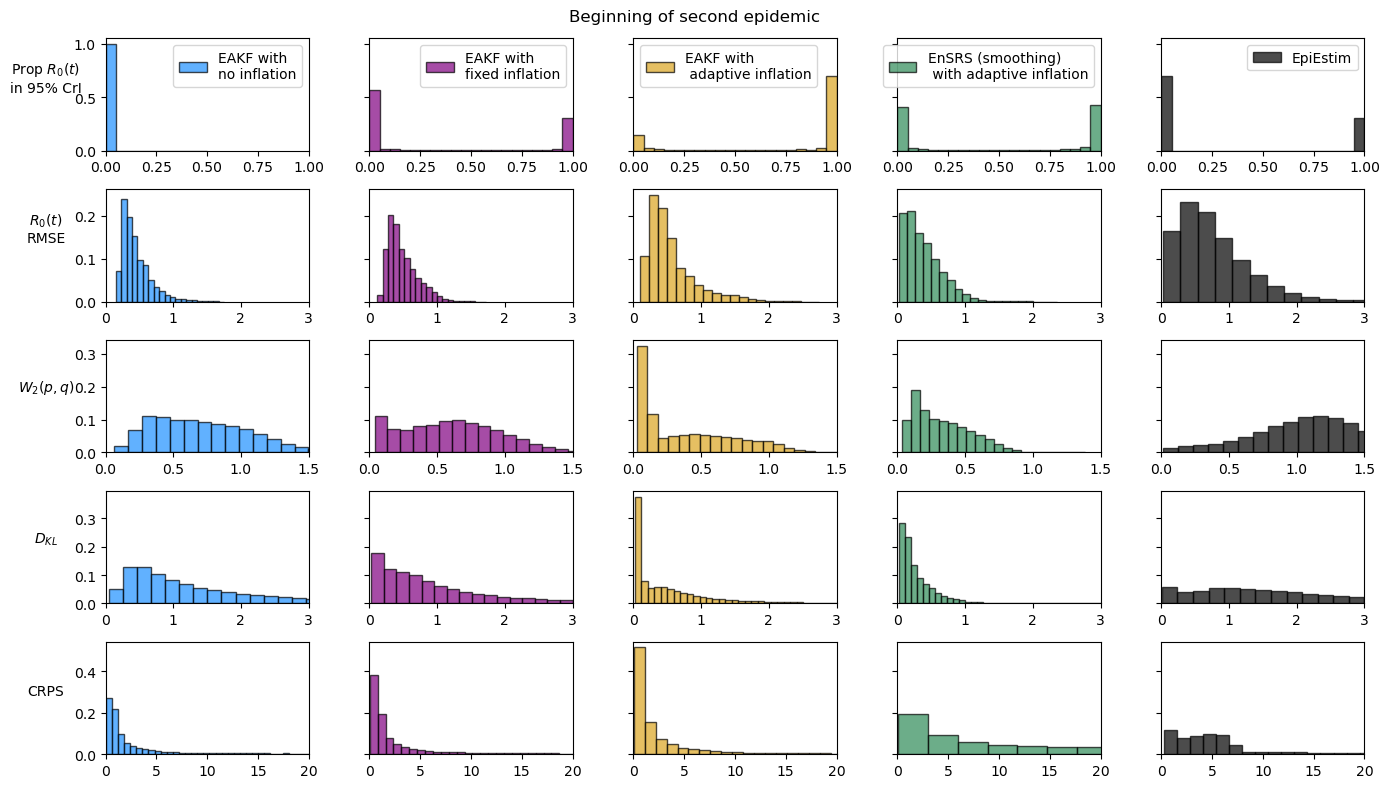

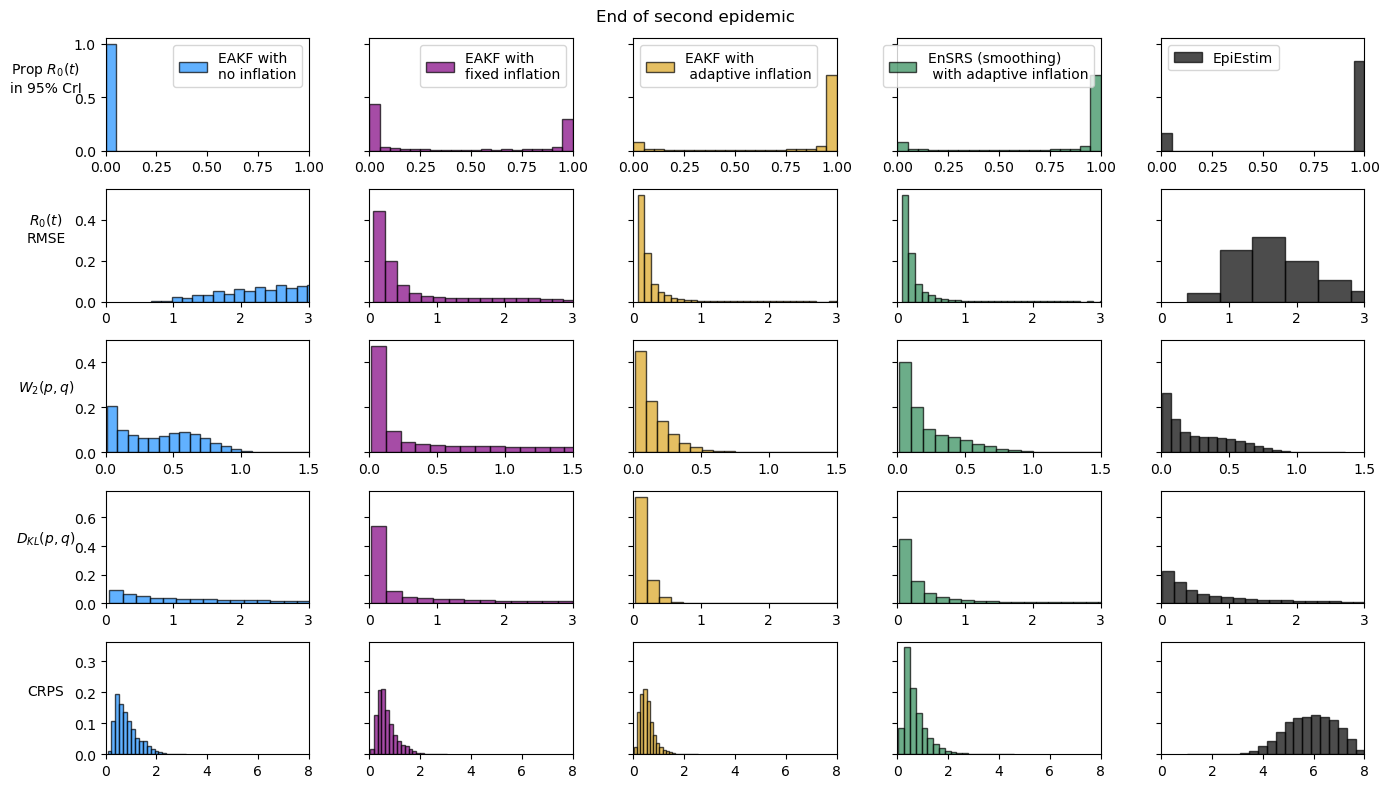

In [14]:
# Creating two separate figures for first and second epidemic days
fig1, axes1 = plt.subplots(nrows=5, ncols=5, figsize=(14,8), sharey='row', sharex='row')
fig2, axes2 = plt.subplots(nrows=5, ncols=5, figsize=(14,8), sharey='row', sharex='row')

# Mapping axes to figures
axes = {'first_epi_day': axes1, 'last_epi_day': axes2}

# Mapping metric to title and row
cols_titles = {
    'in_ci_first_epi_day'   : (0, r'Prop $R_0(t)$' "\n" 'in 95% CrI'),
    'rt_rmse_first_epi_day' : (1, r'$R_0(t)$' "\n" 'RMSE'),
    'avg_w2_first_epi_day'  : (2, r'$W_2(p,q)$'),
    'avg_kl_first_epi_day'  : (3, r'$D_{KL}$'),
    'crps_first_epi_day'    : (4, 'CRPS'),
    'in_ci_last_epi_day'   : (0, r'Prop $R_0(t)$' "\n" 'in 95% CrI'),
    'rt_rmse_last_epi_day' : (1, r'$R_0(t)$' "\n" 'RMSE'),
    'avg_w2_last_epi_day'  : (2, r'$W_2(p,q)$'),
    'avg_kl_last_epi_day'  : (3, r'$D_{KL}(p,q)$'),
    'crps_last_epi_day'    : (4, 'CRPS')
}

methods = ["no inflation", "fixed inflation", "adaptive inflation", "smooth inflation", "epiestim"]
colors = ['dodgerblue', 'purple', 'goldenrod', 'seagreen', 'black']

limits = {
    'in_ci_first_epi_day'   : (0,1),
    'rt_rmse_first_epi_day' : (0,3),
    'avg_w2_first_epi_day'  : (0,1.5),
    'avg_kl_first_epi_day'  : (0,3),
    'crps_first_epi_day'    : (0,20),
    'in_ci_last_epi_day'   : (0,1),
    'rt_rmse_last_epi_day' : (0,3),
    'avg_w2_last_epi_day'  : (0,1.5),
    'avg_kl_last_epi_day'  : (0,3),
    'crps_last_epi_day'    : (0,8)
}

method_dict = {
    "no inflation" : r'EAKF with' '\n' 'no inflation',
    "fixed inflation": 'EAKF with' '\n' 'fixed inflation',
    "adaptive inflation" : 'EAKF with' '\n' ' adaptive inflation',
    "smooth inflation" : 'EnSRS (smoothing)' '\n' ' with adaptive inflation',
    "epiestim" : 'EpiEstim',
}

# Iterating through metrics and plotting
for (col, vals) in cols_titles.items():  # Selecting axes based on the day
    ax = axes["_".join(col.split('_')[-3:])]
    i, title = vals
    # Plotting side-by-side histograms for each method
    for j, method in enumerate(methods):
        if method == "epiestim":
            data = epiestim_metrics_df.loc[epiestim_metrics_df.window == 8 ,[col]]
            if "in_ci" in col:
                data.loc[data[col] == True, col] = 1.
                data.loc[data[col] == False, col] = 0.
            # if col == "crps_first_epi_day":
            #     import pdb; pdb.set_trace()
        else:
            data = eakf_metrics_df.loc[eakf_metrics_df["method"] == method, col]
        
        weights = np.ones_like(data) / len(data)
        
        if "kl" in col:
            nbins=100
        elif col == "crps_first_epi_day" and method == "epiestim":
            nbins=500
        elif col == "crps_first_epi_day":
            nbins=100
        elif col == "rt_rmse_last_epi_day" and (method == "adaptive inflation" or method == "smooth inflation"):
            nbins=200
        else:
            nbins=20
        
        ax[i,j].hist(data, 
                bins=nbins,
                color=colors[j],
                label=method_dict[method],
                edgecolor='black',
                alpha=0.7,
                weights=weights
                )
        
        # Legends and titles
        if ax[i,j] in axes["_".join(col.split('_')[-3:])][0,:]:  # Add legend only to the top row of each figure
            ax[i,j].legend(fontsize=10)

        if j == 0:
            ax[i,j].set_ylabel(title, rotation=0, labelpad=20)  # Add title to each subplot
        ax[i,j].set_xlim(limits[col])

fig1.suptitle("Beginning of second epidemic")
fig2.suptitle("End of second epidemic")

# Adjust layout and show plots
fig1.tight_layout()
fig2.tight_layout()

# print(f"saving to {plot_dir}/metric_dist_beg/end.eps")
# fig1.savefig(f"{plot_dir}/metric_dist_beg.pdf", bbox_inches='tight', transparent=True)
# fig1.savefig(f"{plot_dir}/metric_dist_beg.eps", format='eps', bbox_inches='tight', transparent=True)

# fig2.savefig(f"{plot_dir}/metric_dist_end.pdf", bbox_inches='tight', transparent=True)
# fig2.savefig(f"{plot_dir}/metric_dist_end.eps", format='eps', bbox_inches='tight', transparent=True)

plt.show()


In [15]:
# del adapt_ci, fix_ci, no_ci, epiestim_stats_df, transpose_df
# del epi_transpose_df, eakf_stats_df

# Look for examples params for figures

In [16]:
len(np.unique(eakf_metrics_df.param))

47871

In [17]:
table_cols = [
    'method',
    'in_ci_last_epi_day',
    'rt_rmse_last_epi_day',
    'avg_w2_last_epi_day',
    'avg_kl_last_epi_day',
]

max_params = eakf_metrics_df.iloc[eakf_metrics_df[table_cols].groupby("method").idxmax().values.flatten()].param.unique()
min_params = eakf_metrics_df.iloc[eakf_metrics_df[table_cols].groupby("method").idxmin().values.flatten()].param.unique()

# append the min and max params for epiestim
epiesim_max_params = epiestim_metrics_df.iloc[epiestim_metrics_df.loc[epiestim_metrics_df.window == 8, table_cols[1:]].idxmax().values].param.unique()
epiesim_min_params = epiestim_metrics_df.iloc[epiestim_metrics_df.loc[epiestim_metrics_df.window == 8, table_cols[1:]].idxmin().values].param.unique()

max_params = np.unique(np.append(max_params, epiesim_max_params))
min_params = np.unique(np.append(min_params, epiesim_min_params))

In [18]:
# params that are closest to the mean metric value

mean_df = eakf_metrics_df[table_cols].groupby('method').mean()
mean_df.head()
mean_df.columns = mean_df.columns + "_mean"

mean_diff_df = eakf_metrics_df[table_cols + ['param']].copy()  # No merge

for col in [col for col in table_cols if col != "method"]:
    mean_col_name = col + "_mean"  
    mean_diff_df[col] = mean_diff_df.apply(
        lambda row: np.abs(row[col] - mean_df.loc[row["method"], mean_col_name]), axis=1
    )

min_indices = mean_diff_df.groupby("method")[table_cols].idxmin()  # Avoids flattening
mean_params = mean_diff_df.loc[min_indices.values.ravel(), 'param'].unique()

# # append epiestim mean params
epiestim_mean_df = epiestim_metrics_df.loc[epiestim_metrics_df.window == 8, table_cols[1:]].mean()
mean_params = np.append(mean_params, [epiestim_metrics_df.iloc[np.abs(epiestim_metrics_df.loc[epiestim_metrics_df.window == 8, tt] - epiestim_mean_df[tt]).idxmin()].param for tt in table_cols[1:]])

/tmp/ipykernel_2151695/1349607766.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.idxmin is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  min_indices = mean_diff_df.groupby("method")[table_cols].idxmin()  # Avoids flattening


In [19]:
# max params
max_df = eakf_metrics_df[table_cols].groupby("method").idxmax().stack().reset_index()
max_df.columns = ["method", "metric", "index"]
max_df = max_df.merge(eakf_metrics_df[["param"]], how='left', left_on="index", right_index=True)
max_df.drop("index", axis=1, inplace=True)
max_df = max_df.pivot(index='method', columns='metric', values='param').reset_index()

max_epi_df = pd.DataFrame(epiestim_metrics_df.loc[epiestim_metrics_df.window == 8, table_cols[1:]].idxmax()).reset_index()
max_epi_df.columns = ["metric", "index"]
max_epi_df = max_epi_df.merge(epiestim_metrics_df[["param"]], how='left', left_on="index", right_index=True)
max_epi_df["method"] = "epiestim"
max_epi_df = max_epi_df.pivot(index='method', columns='metric', values='param').reset_index()

max_df = pd.concat([max_df, max_epi_df])
max_df["example"] = "max"

# min params
min_df = eakf_metrics_df[table_cols].groupby("method").idxmin().stack().reset_index()
min_df.columns = ["method", "metric", "index"]
min_df = min_df.merge(eakf_metrics_df[["param"]], how='left', left_on="index", right_index=True)
min_df.drop("index", axis=1, inplace=True)
min_df = min_df.pivot(index='method', columns='metric', values='param').reset_index()

min_epi_df = pd.DataFrame(epiestim_metrics_df.loc[epiestim_metrics_df.window == 8, table_cols[1:]].idxmin()).reset_index()
min_epi_df.columns = ["metric", "index"]
min_epi_df = min_epi_df.merge(epiestim_metrics_df[["param"]], how='left', left_on="index", right_index=True)
min_epi_df["method"] = "epiestim"
min_epi_df = min_epi_df.pivot(index='method', columns='metric', values='param').reset_index()

min_df = pd.concat([min_df, min_epi_df])
min_df["example"] = "min"

# mean params
mean_df = mean_diff_df[table_cols].groupby("method").idxmin().stack().reset_index()
mean_df.columns = ["method", "metric", "index"]
mean_df = mean_df.merge(mean_diff_df[["param"]], how='left', left_on="index", right_index=True)
mean_df.drop("index", axis=1, inplace=True)
mean_df = mean_df.pivot(index='method', columns='metric', values='param').reset_index()


dd = {tt : [epiestim_metrics_df.iloc[np.abs(epiestim_metrics_df.loc[epiestim_metrics_df.window == 8, tt] - epiestim_mean_df[tt]).idxmin()].param] for tt in table_cols[1:]}
mean_epi_df = pd.DataFrame.from_dict(dd)
mean_epi_df["method"] = "epiestim"

mean_df = pd.concat([mean_df, mean_epi_df])
mean_df["example"] = "mean"

list_df = pd.concat([max_df, min_df, mean_df])
list_df.to_csv("example_params_for_plots.csv", index=False)

In [20]:
list_df

,method,avg_kl_last_epi_day,avg_w2_last_epi_day,in_ci_last_epi_day,rt_rmse_last_epi_day,example
0,adaptive inflation,80935,31709,69090,31792,max
1,fixed inflation,46344,52812,73071,31695,max
2,no inflation,78381,78381,46482,32217,max
3,smooth inflation,31709,31709,69090,31792,max
0,epiestim,38846,78381,21258,29853,max
0,adaptive inflation,94196,12208,13462,6981,min
1,fixed inflation,68203,68264,13462,10643,min
2,no inflation,36495,3568,46482,2,min
3,smooth inflation,66860,41496,13462,6981,min
0,epiestim,27645,48137,32258,1444,min


In [21]:
params = np.append(min_params, max_params)
params = np.append(params, mean_params)
params = np.unique(params)

In [22]:
avg_calibration_param = list_df.loc[(list_df['method'] == 'adaptive inflation') & (list_df['example'] == 'mean'), 'in_ci_last_epi_day'].values[0]
avg_rmse_param        = list_df.loc[(list_df['method'] == 'adaptive inflation') & (list_df['example'] == 'mean'), 'rt_rmse_last_epi_day'].values[0]
avg_w2_param          = list_df.loc[(list_df['method'] == 'adaptive inflation') & (list_df['example'] == 'mean'), 'avg_w2_last_epi_day'].values[0]
avg_kl_param          = list_df.loc[(list_df['method'] == 'adaptive inflation') & (list_df['example'] == 'mean'), 'avg_kl_last_epi_day'].values[0]

min_calibration_param = list_df.loc[(list_df['method'] == 'adaptive inflation') & (list_df['example'] == 'min'), 'in_ci_last_epi_day'].values[0]
min_rmse_param        = list_df.loc[(list_df['method'] == 'adaptive inflation') & (list_df['example'] == 'min'), 'rt_rmse_last_epi_day'].values[0]
min_w2_param          = list_df.loc[(list_df['method'] == 'adaptive inflation') & (list_df['example'] == 'min'), 'avg_w2_last_epi_day'].values[0]
min_kl_param          = list_df.loc[(list_df['method'] == 'adaptive inflation') & (list_df['example'] == 'min'), 'avg_kl_last_epi_day'].values[0]

max_calibration_param = list_df.loc[(list_df['method'] == 'adaptive inflation') & (list_df['example'] == 'max'), 'in_ci_last_epi_day'].values[0]
max_rmse_param        = list_df.loc[(list_df['method'] == 'adaptive inflation') & (list_df['example'] == 'max'), 'rt_rmse_last_epi_day'].values[0]
max_w2_param          = list_df.loc[(list_df['method'] == 'adaptive inflation') & (list_df['example'] == 'max'), 'avg_w2_last_epi_day'].values[0]
max_kl_param          = list_df.loc[(list_df['method'] == 'adaptive inflation') & (list_df['example'] == 'max'), 'avg_kl_last_epi_day'].values[0]

In [23]:
plot_dir = "/ifs/scratch/jls106_gp/nhw2114/data/example_plots_for_paper/"

Since I have no space, I deleted the run files for each param (RIP...) and only saved the performance metrics. To be able to plot it, I need to rerun them... UGH...

Run this shell script:
```
eakf_for_plots.sh
```

In [24]:
# csv for array job
# pd.DataFrame(np.unique(params),columns=['param']).to_csv(f"{plot_dir}/plot_params.csv", index=False)

In [25]:
# check if you need to rerun any jobs
files = os.listdir(plot_dir)
done_params = [int(f.split("_")[0]) for f in files if "_adaptive_inflation_run_0.pkl" in f]

to_do_params = list(set(params) - set(done_params))
to_do_params

[]

In [26]:


def open_pickle_rt(pickle_file, smooth=False, plot_dir="/ifs/scratch/jls106_gp/nhw2114/data/example_plots_for_paper/"):
    with open(f"{plot_dir}/{pickle_file}", 'rb') as file:
        data = pickle.load(file)
    if smooth:
        array = np.array([θ.beta*θ.t_I for θ in data.θ_lag_list])
    else:
        array = np.array([θ.beta*θ.t_I for θ in data.θ_list])
    return array

def open_pickle_data(pickle_file, smooth=False, plot_dir="/ifs/scratch/jls106_gp/nhw2114/data/example_plots_for_paper/"):
    with open(f"{plot_dir}/{pickle_file}", 'rb') as file:
        data = pickle.load(file)
    array = np.array([x.i for x in data.x_list])
    data = data.data.i
    return array, data

def compute_ci_mean(array, confidence_level=95):
    ci = np.percentile(array, [100 - confidence_level, confidence_level], axis=1)
    mean = np.mean(array, axis=1)
    return ci, mean

def get_truth(pickle_file, plot_dir="/ifs/scratch/jls106_gp/nhw2114/data/example_plots_for_paper/"):
    with open(f"{plot_dir}/{pickle_file}", 'rb') as file:
        data = pickle.load(file)
    return data.data.rt


# last_day_df = pd.read_csv("/ifs/scratch/jls106_gp/nhw2114/repos/rt-estimation/src/epyfilter/c2b2/last_epidemic_day.csv")
pdf_file = f"{plot_dir}/example_params_rt_obs_metrics.pdf"


adapt_titles = {
    max_calibration_param  : r"Best calibration",
    max_rmse_param         : r"Worst RMSE",
    max_kl_param           : r"Worst $D_{KL}$",
    max_w2_param           : r"Worst $W^2$",
    min_calibration_param  : r"Worst calibration",
    min_rmse_param         : r"Best RMSE",
    min_kl_param           : r"Best $D_{KL}$",
    min_w2_param           : r"Best $W^2$",
    avg_calibration_param  : r"Avg calibration",
    avg_rmse_param         : r"Avg RMSE",
    avg_w2_param           : r"Avg $D_{KL}$",
    avg_kl_param           : r"Avg $W^2$",
}

adapt_params = list(adapt_titles.keys())

pdf_file = f"{plot_dir}/example_adapt_params_rt_obs_metrics.pdf"
with PdfPages(pdf_file) as pdf:
    for pp in tqdm(adapt_params):
    # for pp in tqdm(params):
        epiestim_df = pd.read_csv(f"{in_dir}/{pp}_epiEstim_for_plot.csv")
        epiestim_df = epiestim_df.loc[epiestim_df.window == 8]
        # last_day = last_day_df.loc[last_day_df.param == pp, 'last_epidemic_day'].values[0]
        for run in range(1):
            no_pickle_file = f"{pp}_no_inflation_run_{run}.pkl"
            fixed_pickle_file = f"{pp}_fixed_inflation_run_{run}.pkl"
            adapt_pickle_file = f"{pp}_adaptive_inflation_run_{run}.pkl"
            smooth_pickle_file = f"{pp}_smooth_inflation_run_{run}.pkl"

            # get rt estimates and truth
            truth = get_truth(no_pickle_file)
            ci_no, mean_no = compute_ci_mean(open_pickle_rt(no_pickle_file))
            ci_fixed, mean_fixed = compute_ci_mean(open_pickle_rt(fixed_pickle_file))
            ci_adapt, mean_adapt = compute_ci_mean(open_pickle_rt(adapt_pickle_file))
            ci_smooth, mean_smooth = compute_ci_mean(open_pickle_rt(smooth_pickle_file, smooth=True))

            i_no, i_obs = open_pickle_data(no_pickle_file)
            ci_i_no, mean_i_no = compute_ci_mean(i_no)
            i_fixed, _ = open_pickle_data(fixed_pickle_file)
            ci_i_fixed, mean_i_fixed = compute_ci_mean(i_fixed)
            i_adapt, _ = open_pickle_data(adapt_pickle_file)
            ci_i_adapt, mean_i_adapt = compute_ci_mean(i_adapt)
            i_smooth, _ = open_pickle_data(smooth_pickle_file)
            ci_i_smooth, mean_i_smooth = compute_ci_mean(i_smooth)

            fig, ax = plt.subplots(2,2)
            fig.suptitle(adapt_titles[pp])
            fig.set_figheight(12)
            fig.set_figwidth(16)

            # plot Rt
            ax[0,0].fill_between(np.arange(ci_no.shape[1]), ci_no[0,:], ci_no[1,:], color='blue', alpha=0.3)
            ax[0,0].plot(mean_no, color="blue", label=r"EAKF with no inflation")

            ax[0,0].fill_between(np.arange(ci_fixed.shape[1]), ci_fixed[0,:], ci_fixed[1,:], color='purple', alpha=0.3)
            ax[0,0].plot(mean_fixed, color="purple", label=r"EAKF with fixed inflation")

            ax[0,0].fill_between(np.arange(ci_adapt[0,:].shape[0]), ci_adapt[0,:], ci_adapt[1,:], color='yellow', alpha=0.3)
            ax[0,0].plot(mean_adapt, color="orange", label=r"EAKF with adaptive inflation")

            ax[0,0].fill_between(np.arange(ci_smooth.shape[1]), ci_smooth[0,:], ci_smooth[1,:], color='green', alpha=0.3)
            ax[0,0].plot(mean_smooth, color="green", label=r"EnSRS (smoothing) with adaptive inflation")

            ax[0,0].fill_between(epiestim_df.day, epiestim_df['2.5%'], epiestim_df['97.5%'], color='grey', alpha=0.3)
            ax[0,0].plot(epiestim_df.day, epiestim_df['mean'], color='black', label=r"EpiEstim")

            # ax[0,0].vlines(last_day, 0.01, ax[0,0].get_ylim()[1], color='steelblue', label='last epi day')

            ax[0,0].plot(truth, color="red", label=r"Synthetic truth")

            ax[0,0].set_xlabel("day", fontsize=12)
            ax[0,0].set_ylabel(r"$R_t$", fontsize=12)

            ax[0,0].legend()
            ax[0,0].grid(linestyle='dotted')

            param_dict = param_df.iloc[pp-1][['rt_0', 'rt_1', 'k', 'midpoint']]
            ax[0,0].set_title(f"param {pp} run {run} {round(param_dict,3).to_dict()}")

            # table for metrics
            pp_kf_df = eakf_metrics_df.loc[eakf_metrics_df.param == pp, table_cols].round(3)
            pp_ep_df = epiestim_metrics_df.loc[(epiestim_metrics_df.window == 8) & (epiestim_metrics_df.param == pp), table_cols[1:]].round(3)
            pp_ep_df['method'] = 'epiestim'

            pp_df = pd.concat([pp_kf_df, pp_ep_df])
            custom_order = ['no inflation', 'fixed inflation', 'adaptive inflation', 'smooth inflation', 'epiestim']
            pp_df['method'] = pd.Categorical(pp_df['method'], categories=custom_order, ordered=True)
            pp_df = pp_df.sort_values(by='method')

            ax[0,1].axis('off')
            table = ax[0,1].table(cellText=pp_df.values, colLabels=pp_df.columns, loc='center')
            table.set_fontsize(24)
            table.scale(1.3, 1.3)

            # plot i
            ax[1,0].fill_between(np.arange(ci_i_no.shape[1]), ci_i_no[0,:], ci_i_no[1,:], color='blue', alpha=0.3)
            ax[1,0].plot(mean_i_no, color="blue", label=r"EAKF with no inflation")

            ax[1,0].fill_between(np.arange(ci_i_fixed.shape[1]), ci_i_fixed[0,:], ci_i_fixed[1,:], color='purple', alpha=0.3)
            ax[1,0].plot(mean_i_fixed, color="purple", label=r"EAKF with fixed inflation")

            ax[1,0].fill_between(np.arange(ci_i_adapt[0,:].shape[0]), ci_i_adapt[0,:], ci_i_adapt[1,:], color='yellow', alpha=0.3)
            ax[1,0].plot(mean_i_adapt, color="orange", label=r"EAKF with adaptive inflation")

            ax[1,0].fill_between(np.arange(ci_i_smooth.shape[1]), ci_i_smooth[0,:], ci_i_smooth[1,:], color='green', alpha=0.3)
            ax[1,0].plot(mean_i_smooth, color="green", label=r"EnSRS (smoothing) with adaptive inflation")

            # ax[1,0].vlines(last_day, 0.01, ax[1,0].get_ylim()[1], color='steelblue', label='last epi day')

            ax[1,0].plot(i_obs, '.', color='red', label='observations')

            ax[1,0].set_xlabel("day", fontsize=12)
            ax[1,0].set_ylabel(r"daily case counts", fontsize=12)

            ax[1,0].legend()
            ax[1,0].grid(linestyle='dotted')


            ax[1,1].axis('off')

            pdf.savefig(fig)
            plt.close()

            # plt.savefig(f'rt.svg', format='svg', bbox_inches='tight', transparent=True)

        

100%|██████████| 12/12 [00:08<00:00,  1.36it/s]


## Number plug for Fig 2 paragraph

In [27]:
with open(f"{plot_dir}/{min_rmse_param}_adaptive_inflation_run_{run}.pkl", 'rb') as file:
    kf_adapt_obj = pickle.load(file)

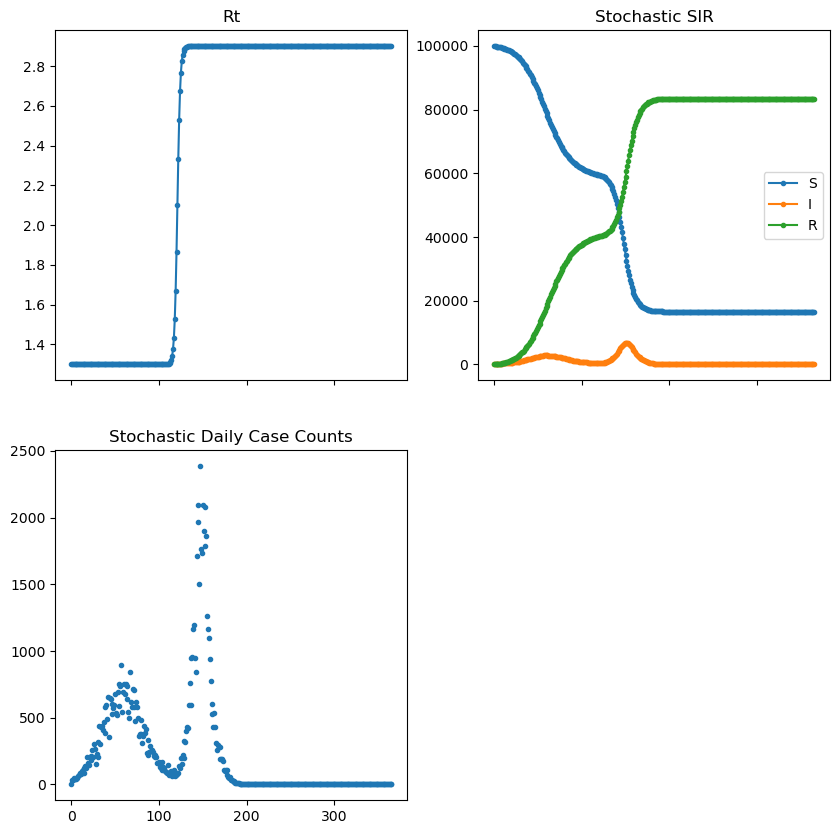

In [28]:
kf_adapt_obj.data.plot_all()

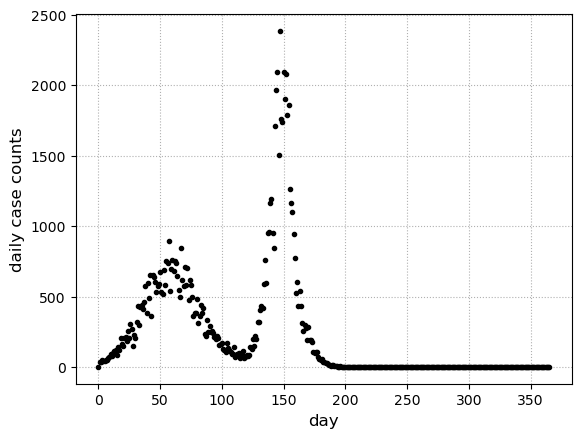

In [29]:
fig, ax = plt.subplots()

ax.plot(kf_adapt_obj.data.i, '.', color='black')
ax.set_xlabel("day", fontsize=12)
ax.set_ylabel(r"daily case counts", fontsize=12)
ax.grid(linestyle='dotted')


In [30]:
eakf_metrics_df.columns

Index(['method', 'rt_rmse_up_to_last_epi_day', 'rt_rmse_last_epi_day',
       'avg_w2_up_to_last_epi_day', 'avg_w2_last_epi_day',
       'avg_kl_up_to_last_epi_day', 'avg_kl_last_epi_day',
       'in_ci_last_epi_day', 'crps_last_epi_day',
       'rt_rmse_up_to_first_epi_day', 'rt_rmse_first_epi_day',
       'avg_w2_up_to_first_epi_day', 'avg_w2_first_epi_day',
       'avg_kl_up_to_first_epi_day', 'avg_kl_first_epi_day',
       'in_ci_first_epi_day', 'crps_first_epi_day', 'param'],
      dtype='object')

In [31]:
eakf_metrics_df.loc[
    eakf_metrics_df.param == min_rmse_param,
    ['method', 'avg_kl_up_to_first_epi_day', 'avg_w2_up_to_first_epi_day', 'avg_kl_up_to_last_epi_day', 'avg_w2_up_to_last_epi_day']].round(2)

,method,avg_kl_up_to_first_epi_day,avg_w2_up_to_first_epi_day,avg_kl_up_to_last_epi_day,avg_w2_up_to_last_epi_day
11460,adaptive inflation,0.90,0.74,1.02,0.80
11461,fixed inflation,1.19,0.75,4.35,1.01
11462,no inflation,1.74,0.85,8.23,1.14
11463,smooth inflation,1.88,0.46,1.30,0.40


In [32]:
epiestim_metrics_df.loc[(epiestim_metrics_df.param == min_rmse_param) & (epiestim_metrics_df.window == 8),
                        ['avg_kl_up_to_first_epi_day', 'avg_w2_up_to_first_epi_day', 'avg_kl_up_to_last_epi_day', 'avg_w2_up_to_last_epi_day']
                       ].round(2)

,avg_kl_up_to_first_epi_day,avg_w2_up_to_first_epi_day,avg_kl_up_to_last_epi_day,avg_w2_up_to_last_epi_day
570687,2.48,0.5,4.7,0.73


## Best RMSE for adaptive inflation plot

In [33]:
param_df = pd.read_csv("param_list.csv")
param_df.iloc[min_rmse_param]

rt_0             1.3
rt_1             2.9
midpoint       121.0
k                0.7
n_t            365.0
t_I              4.0
N           100000.0
S0           99900.0
I0             100.0
Name: 6981, dtype: float64

In [34]:
param_df.I0.unique()

array([100])

In [35]:
last_epi_days_df = pd.read_csv("compute_days.csv")
last_epi_days_df.loc[last_epi_days_df.param == min_rmse_param]

,param,late_day,peak1,peak2,last_epi_day,first_epi_day
2865,6981,127,62,146,195,118


In [36]:
def plot_rt_posterior(pp, last_plot_day=None, plot_error_bar=False, save=False):
    epiestim_df = pd.read_csv(f"{in_dir}/{pp}_epiEstim_for_plot.csv")
    epiestim_df = epiestim_df.loc[epiestim_df.window == 8]
    
    first_day = last_epi_days_df.loc[last_epi_days_df.param == pp, 'first_epi_day'].values[0]
    last_day = last_epi_days_df.loc[last_epi_days_df.param == pp, 'last_epi_day'].values[0]
    
    for run in range(1):
        no_pickle_file = f"{pp}_no_inflation_run_{run}.pkl"
        fixed_pickle_file = f"{pp}_fixed_inflation_run_{run}.pkl"
        adapt_pickle_file = f"{pp}_adaptive_inflation_run_{run}.pkl"
        smooth_pickle_file = f"{pp}_smooth_inflation_run_{run}.pkl"

        # get rt estimates and truth
        truth = get_truth(no_pickle_file)
        ci_no, mean_no = compute_ci_mean(open_pickle_rt(no_pickle_file))
        ci_fixed, mean_fixed = compute_ci_mean(open_pickle_rt(fixed_pickle_file))
        ci_adapt, mean_adapt = compute_ci_mean(open_pickle_rt(adapt_pickle_file))
        ci_smooth, mean_smooth = compute_ci_mean(open_pickle_rt(smooth_pickle_file, smooth=True))

        i_no, i_obs = open_pickle_data(no_pickle_file)
        ci_i_no, mean_i_no = compute_ci_mean(i_no)
        i_fixed, _ = open_pickle_data(fixed_pickle_file)
        ci_i_fixed, mean_i_fixed = compute_ci_mean(i_fixed)
        i_adapt, _ = open_pickle_data(adapt_pickle_file)
        ci_i_adapt, mean_i_adapt = compute_ci_mean(i_adapt)
        i_smooth, _ = open_pickle_data(smooth_pickle_file)
        ci_i_smooth, mean_i_smooth = compute_ci_mean(i_smooth)
        
        if last_plot_day:
            mean_no       = mean_no[:last_plot_day]
            mean_fixed    = mean_fixed[:last_plot_day]
            mean_adapt    = mean_adapt[:last_plot_day]
            mean_smooth   = mean_smooth[:last_plot_day]
            
            ci_no     = ci_no[:,:last_plot_day]
            ci_fixed  = ci_fixed[:,:last_plot_day]
            ci_adapt  = ci_adapt[:,:last_plot_day]
            ci_smooth = ci_smooth[:,:last_plot_day]
            
            truth = truth[:last_plot_day]
            
            mean_i_no       = mean_i_no[:last_plot_day]
            mean_i_fixed    = mean_i_fixed[:last_plot_day]
            mean_i_adapt    = mean_i_adapt[:last_plot_day]
            mean_i_smooth   = mean_i_smooth[:last_plot_day]
            
            ci_i_no     = ci_i_no[:,:last_plot_day]
            ci_i_fixed  = ci_i_fixed[:,:last_plot_day]
            ci_i_adapt  = ci_i_adapt[:,:last_plot_day]
            ci_i_smooth = ci_i_smooth[:,:last_plot_day]
            
            epiestim_df = epiestim_df[epiestim_df.day <= last_plot_day]
        
        fig, ax = plt.subplots()
        fig.suptitle(r"$R_0(t)$ posterior distribution")
        fig.set_figheight(6)
        fig.set_figwidth(8)
        
        # plot Rt
        if plot_error_bar:
            ax.errorbar(np.arange(ci_no.shape[1]), mean_no, np.abs(ci_no - mean_no), color='dodgerblue', fmt='-', elinewidth=1, capsize=3, alpha=0.7, label=r"EAKF with no inflation")
            
            ax.errorbar(np.arange(ci_fixed.shape[1]), mean_fixed, np.abs(ci_fixed - mean_fixed), color='purple', fmt='-', elinewidth=1, capsize=3, alpha=0.7, errorevery=5, label=r"EAKF with fixed inflation")

            ax.errorbar(np.arange(ci_adapt[0,:].shape[0]), mean_adapt, np.abs(ci_adapt - mean_adapt), color='goldenrod', fmt='-', elinewidth=1, capsize=3, alpha=0.7, errorevery=5, label=r"EAKF with adaptive inflation")

            ax.errorbar(np.arange(ci_smooth.shape[1]), mean_smooth, np.abs(ci_smooth - mean_smooth), color='seagreen', fmt='-', elinewidth=1, capsize=3, alpha=0.7, errorevery=5, label=r"EnSRS (smoothing) with adaptive inflation")

            ax.errorbar(epiestim_df.day, epiestim_df['mean'], np.stack((np.abs(epiestim_df['mean'] - epiestim_df['2.5%']), np.abs(epiestim_df['mean'] - epiestim_df['97.5%']))), color='black', fmt='-', elinewidth=1, capsize=3, alpha=0.7, errorevery=5, label=r"EpiEstim")

            # ax[0,0].vlines(last_day, 0.01, ax[0,0].get_ylim()[1], color='steelblue', label='last epi day')
            ax.plot(truth, color="firebrick", linestyle='dashed', label=r"Synthetic truth")
        else:
            ax.fill_between(np.arange(ci_no.shape[1]), ci_no[0,:], ci_no[1,:], color='dodgerblue', alpha=0.3)
            ax.plot(mean_no, color="dodgerblue", label=r"EAKF with no inflation")

            ax.fill_between(np.arange(ci_fixed.shape[1]), ci_fixed[0,:], ci_fixed[1,:], color='purple', alpha=0.3)
            ax.plot(mean_fixed, color="purple", label=r"EAKF with fixed inflation")

            ax.fill_between(np.arange(ci_adapt[0,:].shape[0]), ci_adapt[0,:], ci_adapt[1,:], color='goldenrod', alpha=0.3)
            ax.plot(mean_adapt, color="goldenrod", label=r"EAKF with adaptive inflation")

            ax.fill_between(np.arange(ci_smooth.shape[1]), ci_smooth[0,:], ci_smooth[1,:], color='seagreen', alpha=0.3)
            ax.plot(mean_smooth, color="seagreen", label=r"EnSRS (smoothing) with adaptive inflation")

            ax.fill_between(epiestim_df.day, epiestim_df['2.5%'], epiestim_df['97.5%'], color='grey', alpha=0.3)
            ax.plot(epiestim_df.day, epiestim_df['mean'], color='black', label=r"EpiEstim")

            ax.plot(truth, color="red", linestyle='dashed', label=r"Synthetic truth")
            

        ax.set_xlabel("day", fontsize=12)
        ax.set_ylabel(r"$R_0(t)$", fontsize=12)

        ax.legend()
        ax.grid(linestyle='dotted')
        
        # add minor ticks for first and last epi day
        extraticks = [first_day, last_day]
        loc = matplotlib.ticker.FixedLocator(extraticks)
        ax.xaxis.set_minor_locator(loc)
        ax.grid(which='minor', color='red', linestyle='dotted')


        # param_dict = param_df.iloc[pp-1][['rt_0', 'rt_1', 'k', 'midpoint']]
        # ax.set_title(f"param {pp} run {run} {round(param_dict,3).to_dict()}")
        
        fig.tight_layout()
        
        if save:
            print(f"saving to {plot_dir}/{pp}_rt_posterior_plot.eps")
            plt.savefig(f"{plot_dir}/{pp}_rt_posterior_plot.pdf", bbox_inches='tight', transparent=True)
            plt.savefig(f"{plot_dir}/{pp}_rt_posterior_plot.eps", format='eps', bbox_inches='tight', transparent=True)
        
        plt.show()

6981


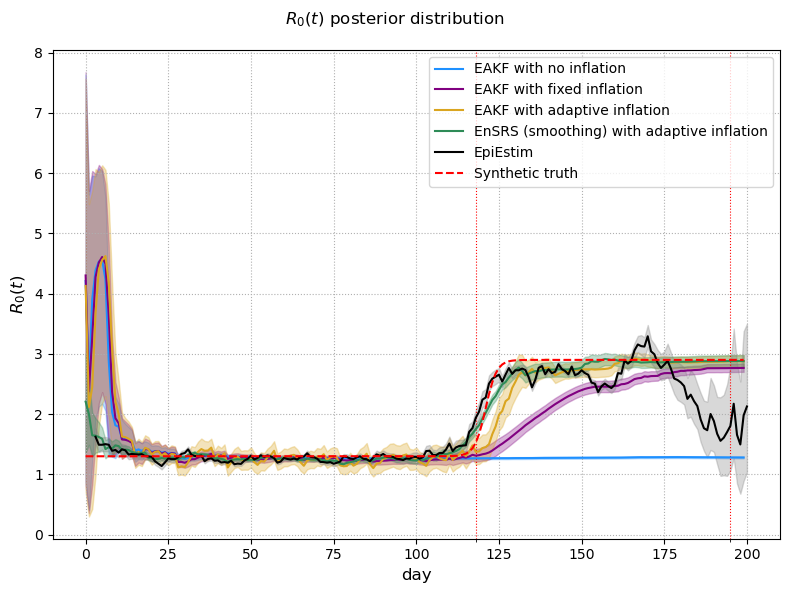

In [37]:
print(min_rmse_param)
plot_rt_posterior(min_rmse_param, 200)

THIS LOOKS DUMB

In [38]:
import matplotlib.gridspec as gridspec
import matplotlib.lines as mlines

def get_true_data_distribution(pickle_file, plot_dir="/ifs/scratch/jls106_gp/nhw2114/data/example_plots_for_paper/"):
    with open(f"{plot_dir}/{pickle_file}", 'rb') as file:
        data = pickle.load(file)
    return data.data.data_distribution
    
def get_kf_obj(pickle_file, smooth=False, plot_dir="/ifs/scratch/jls106_gp/nhw2114/data/example_plots_for_paper/"):
    with open(f"{plot_dir}/{pickle_file}", 'rb') as file:
        data = pickle.load(file)
    return data
    


def plot_ppd(pp, save=False):
    # last_day = last_day_df.loc[last_day_df.param == pp, 'last_epidemic_day'].values[0]
    
    no_pickle_file     = f"{pp}_no_inflation_run_{run}.pkl"
    fixed_pickle_file  = f"{pp}_fixed_inflation_run_{run}.pkl"
    adapt_pickle_file  = f"{pp}_adaptive_inflation_run_{run}.pkl"
    smooth_pickle_file = f"{pp}_smooth_inflation_run_{run}.pkl"
    epiestim_ippc_file = f"{epiestim_in_dir}/{pp}_epiEstim_i_ppc.csv"
    
    first_day = last_epi_days_df.loc[last_epi_days_df.param == pp, 'first_epi_day'].values[0]
    last_day = last_epi_days_df.loc[last_epi_days_df.param == pp, 'last_epi_day'].values[0]
    
    kf_no = get_kf_obj(no_pickle_file)
    kf_fixed = get_kf_obj(fixed_pickle_file)
    kf_adapt = get_kf_obj(adapt_pickle_file)
    kf_smooth = get_kf_obj(smooth_pickle_file)
    epiestim_df = pd.read_csv(epiestim_ippc_file)
    truth = get_true_data_distribution(no_pickle_file)
    
    fig = plt.figure(figsize=(7.5, 8.75))
    gs = gridspec.GridSpec(4, 2, width_ratios=[1, 1], height_ratios=[1, 1, 1, 1])

    ax1 = plt.subplot(gs[0, 0])
    ax1.plot(truth, color="indianred", alpha=0.01)
    ax1.plot(np.mean(truth, axis=1), color='firebrick')

    ax2 = plt.subplot(gs[1,0], sharey=ax1)
    ax2.plot(kf_no.i_ppc, color="dodgerblue", alpha=0.01)
    ax2.plot(np.mean(kf_no.i_ppc, axis=1), color='dodgerblue')
    ax2.plot(np.mean(truth, axis=1), color='firebrick')

    ax3 = plt.subplot(gs[2,0], sharey=ax1)
    ax3.plot(kf_fixed.i_ppc, color="purple", alpha=0.01)
    ax3.plot(np.mean(kf_fixed.i_ppc, axis=1), color='purple')
    ax3.plot(np.mean(truth, axis=1), color='firebrick')

    ax4 = plt.subplot(gs[0,1])
    ax4.plot(kf_no.lam_list, color="blue")
    ax4.plot(kf_fixed.lam_list[0] * np.ones(len(kf_fixed.lam_list)), color="purple")
    ax4.plot(kf_adapt.lam_list, color='goldenrod')
    ax4.set_ylabel(r'$\lambda$')

    ax5 = plt.subplot(gs[1,1], sharey=ax1)
    ax5.plot(kf_adapt.i_ppc, color="goldenrod", alpha=0.01)
    ax5.plot(np.mean(kf_adapt.i_ppc, axis=1), color='goldenrod')
    ax5.plot(np.mean(truth, axis=1), color='firebrick')

    ax6 = plt.subplot(gs[2,1], sharey=ax1)
    ax6.plot(kf_smooth.i_ppc, color="seagreen", alpha=0.01)
    ax6.plot(np.mean(kf_smooth.i_ppc, axis=1), color='mediumseagreen')
    ax6.plot(np.mean(truth, axis=1), color='firebrick')

    ax7 = plt.subplot(gs[3,0], sharey=ax1)
    ax7.plot(epiestim_df, color="gray", alpha=0.01)
    ax7.plot(np.mean(epiestim_df, axis=1), color="black")
    ax7.plot(np.mean(truth, axis=1), color='firebrick')
    
    
    ax1.grid(linestyle='dotted')
    ax2.grid(linestyle='dotted')
    ax3.grid(linestyle='dotted')
    ax4.grid(linestyle='dotted')
    ax5.grid(linestyle='dotted')
    ax6.grid(linestyle='dotted')
    ax7.grid(linestyle='dotted')

    plt.subplots_adjust(hspace = 0.5, wspace=0.3)
    fig.text(0, 0.5, 'daily case counts', va='center', rotation='vertical')
    fig.text(0.5, 0.01, 'day', ha='center')
    plt.figtext(0.5, 0.71, 'Posterior predictive distributions', ha="center", va="top", fontsize=12)


    red_line = mlines.Line2D([], [], color='firebrick', linestyle='-')
    blue_line = mlines.Line2D([], [], color='dodgerblue', linestyle='-')
    purple_line = mlines.Line2D([], [], color='purple', linestyle='-')
    orange_line = mlines.Line2D([], [], color='goldenrod', linestyle='-')
    green_line = mlines.Line2D([], [], color='seagreen', linestyle='-')
    black_line = mlines.Line2D([], [], color='gray', linestyle='-')
    
    # add minor ticks for first and last epi day
    extraticks = [first_day, last_day]
    loc = matplotlib.ticker.FixedLocator(extraticks)
    for aa in [ax1, ax2, ax3, ax4, ax5, ax6, ax7]:
        aa.xaxis.set_minor_locator(loc)
        aa.grid(which='minor', color='red', linestyle='dotted')


    handles = [red_line, blue_line, purple_line, orange_line, green_line, black_line]
    labels = ['Data distribution', 'EAKF with no inflation', 'EAKF with fixed inflation', 'EAKF with adaptive inflation', 'EnSRS (smoothing) with adaptive inflation', 'EpiEstim']
    # Place the legend outside the plots
    fig.legend(handles, labels, loc='upper left')
    
    
    if save:
        print(f"saving to {plot_dir}/{pp}_ppd.eps")
        plt.savefig(f"{plot_dir}/{pp}_ppd.pdf", bbox_inches='tight', transparent=True)
        plt.savefig(f"{plot_dir}/{pp}_ppd.eps", format='eps', bbox_inches='tight', transparent=True)
    
    plt.show()

6981


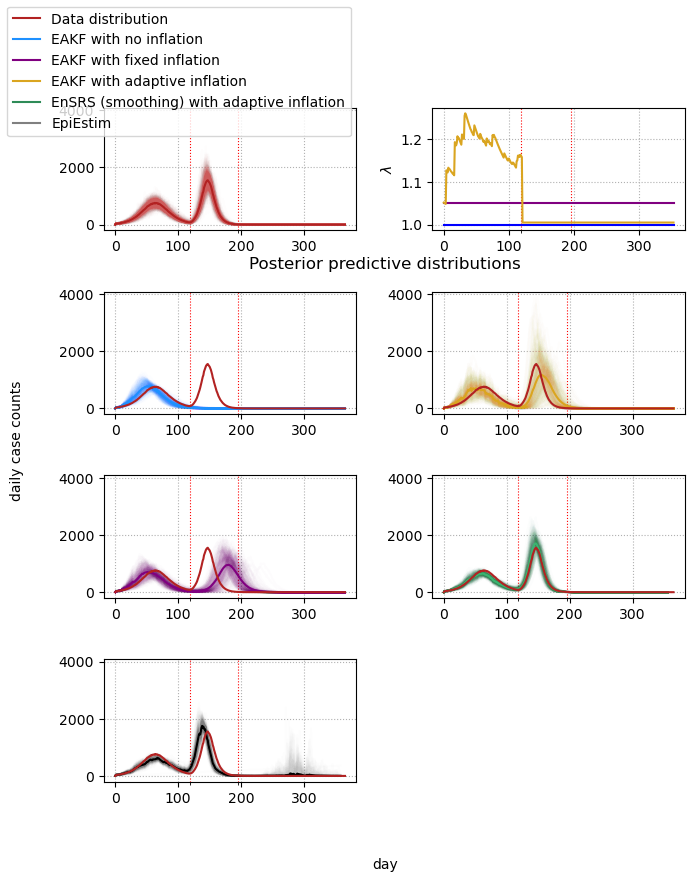

In [39]:
print(min_rmse_param)
plot_ppd(min_rmse_param)

## Plot exactly at last epi day

saving to /ifs/scratch/jls106_gp/nhw2114/data/example_plots_for_paper//6981_rt_posterior_plot_last_epi_day_subset.eps


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


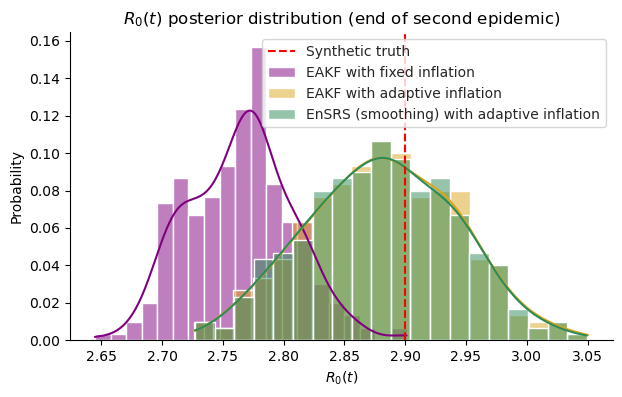

In [40]:
import seaborn as sns


def plot_hist_at_point(pp, day, fname, plot_no_inf=False, save=True):
        
    no_pickle_file      = f"{pp}_no_inflation_run_{run}.pkl"
    fixed_pickle_file   = f"{pp}_fixed_inflation_run_{run}.pkl"
    adapt_pickle_file   = f"{pp}_adaptive_inflation_run_{run}.pkl"
    smooth_pickle_file  = f"{pp}_smooth_inflation_run_{run}.pkl"
    epiestim_file       = f"{epiestim_in_dir}/{pp}_epiEstim_post.csv"
    
    truth = get_truth(no_pickle_file)[day]
    
    no_hist = open_pickle_rt(no_pickle_file)[day]
    fixed_hist = open_pickle_rt(fixed_pickle_file)[day]
    adapt_hist = open_pickle_rt(adapt_pickle_file)[day]
    smooth_hist = open_pickle_rt(smooth_pickle_file, smooth=True)[day]
    epiestim_hist = pd.read_csv(epiestim_file)
    epiestim_hist = epiestim_hist.loc[epiestim_hist.day == day].filter(regex="sample").values.T.squeeze()

    
    fig, ax = plt.subplots(figsize=(7, 4))
    
    
    sns.set_style("ticks")
    
    if plot_no_inf:
        sns.histplot(no_hist, bins=1, kde=False, stat="probability", label="EAKF with no inflation", color="dodgerblue", alpha=0.5, ax=ax)
        sns.histplot(epiestim_hist, bins=20, kde=True, stat="probability", label="EpiEstim", color="black", alpha=0.5, ax=ax)
    sns.histplot(fixed_hist, bins=20, kde=True, stat="probability", label="EAKF with fixed inflation", color="purple", alpha=0.5, ax=ax)
    sns.histplot(adapt_hist, bins=20, kde=True, stat="probability", label="EAKF with adaptive inflation", color="goldenrod", alpha=0.5, ax=ax)
    sns.histplot(smooth_hist, bins=20, kde=True, stat="probability", label="EnSRS (smoothing) with adaptive inflation", color="seagreen", alpha=0.5, ax=ax)
    
    # Ground truth (vertical line)
    ax.axvline(truth, color='red', linestyle='dashed', linewidth=1.5, label="Synthetic truth")

    # Formatting
    ax.set_xlabel(r"$R_0(t)$")  # Assuming R(t) is your estimate
    # ax.set_ylabel("Density")
    ax.set_title(r"$R_0(t)$ posterior distribution (end of second epidemic)", fontsize=12)  
    ax.legend(fontsize=10)
    sns.despine()  # Remove top and right spines
    
    if save:
        print(f"saving to {plot_dir}/{pp}_{fname}.eps")
        plt.savefig(f"{plot_dir}/{pp}_{fname}.pdf", bbox_inches='tight', transparent=True)
        plt.savefig(f"{plot_dir}/{pp}_{fname}.eps", format='eps', bbox_inches='tight', transparent=True)

    return fig

last_epi_day = last_epi_days_df.loc[last_epi_days_df.param == min_rmse_param, "last_epi_day"].values[0]
fig = plot_hist_at_point(min_rmse_param, last_epi_day, fname="rt_posterior_plot_last_epi_day_subset")

saving to /ifs/scratch/jls106_gp/nhw2114/data/example_plots_for_paper//6981_rt_posterior_plot_last_epi_day.eps


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


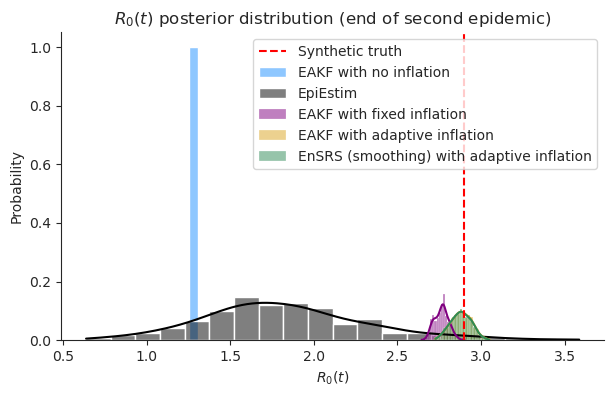

In [41]:
fig = plot_hist_at_point(min_rmse_param, last_epi_day, fname="rt_posterior_plot_last_epi_day", plot_no_inf=True)

In [42]:
def plot_ppd_hist_at_point(pp, day, fname, plot_good=False, save=False):
    
    no_pickle_file      = f"{pp}_no_inflation_run_{run}.pkl"
    fixed_pickle_file   = f"{pp}_fixed_inflation_run_{run}.pkl"
    adapt_pickle_file   = f"{pp}_adaptive_inflation_run_{run}.pkl"
    smooth_pickle_file  = f"{pp}_smooth_inflation_run_{run}.pkl"
    epiestim_file       = f"{epiestim_in_dir}/{pp}_epiEstim_i_ppc.csv"
    
    kf_no = get_kf_obj(no_pickle_file).i_ppc[day]
    kf_fixed = get_kf_obj(fixed_pickle_file).i_ppc[day]
    kf_adapt = get_kf_obj(adapt_pickle_file).i_ppc[day]
    kf_smooth = get_kf_obj(smooth_pickle_file).i_ppc[day]
    truth = get_true_data_distribution(no_pickle_file)[day]
    
    epiestim_i_ppc = pd.read_csv(epiestim_file)
    epiestim_i_ppc = epiestim_i_ppc[epiestim_i_ppc.day == day].filter(regex='sample').values.T.squeeze()
    
    fig, ax = plt.subplots(figsize=(7, 4))
    
    sns.set_style("ticks")  # PLOS style
    
    if plot_good:
        sns.histplot(kf_no, bins=20, kde=False, stat='probability', label="EAKF with no inflation", color="dodgerblue", alpha=0.5, ax=ax)
        # sns.histplot(kf_adapt, bins=20, kde=True, stat='probability', label="EAKF with adaptive inflation", color="goldenrod", alpha=0.5, ax=ax)
        sns.histplot(kf_smooth, bins=20, kde=True,  stat='probability', label="EnSRS (smoothing) with adaptive inflation", color="seagreen", alpha=0.5, ax=ax)
        sns.histplot(truth, color='red', bins=20, kde=True,  stat='probability', label="Synthetic truth", alpha=0.5, ax=ax)
        sns.histplot(epiestim_i_ppc, bins=20, kde=True,  stat='probability', color='black', label="EpiEstim", alpha=0.5, ax=ax)
    else:
        sns.histplot(kf_no, bins=20, kde=False, stat='probability', label="EAKF with no inflation", color="dodgerblue", alpha=0.5, ax=ax)
        sns.histplot(kf_fixed, bins=20, kde=True, stat='probability', label="EAKF with fixed inflation", color="purple", alpha=0.5, ax=ax)
        sns.histplot(kf_adapt, bins=20, kde=True, stat='probability', label="EAKF with adaptive inflation", color="goldenrod", alpha=0.5, ax=ax)
        sns.histplot(kf_smooth, bins=20, kde=True,  stat='probability', label="EnSRS (smoothing) with adaptive inflation", color="seagreen", alpha=0.5, ax=ax)
        sns.histplot(truth, color='red', bins=20, kde=True,  stat='probability', label="Synthetic truth", alpha=0.5, ax=ax)
        sns.histplot(epiestim_i_ppc, bins=20, kde=True,  stat='probability', label="EpiEstim", color='black', alpha=0.5, ax=ax)

    # Formatting
    ax.set_xlabel(r"daily case counts")  # Assuming R(t) is your estimate
    ax.set_title(r"Posterior predictive distributions (end of second epidemic)", fontsize=12)  
    ax.legend(fontsize=10)
    sns.despine()  # Remove top and right spines
    
    if save:
        print(f"saving to {plot_dir}/{pp}_{fname}.eps")
        plt.savefig(f"{plot_dir}/{pp}_{fname}.pdf", bbox_inches='tight', transparent=True)
        plt.savefig(f"{plot_dir}/{pp}_{fname}.eps", format='eps', bbox_inches='tight', transparent=True)

    
    return fig

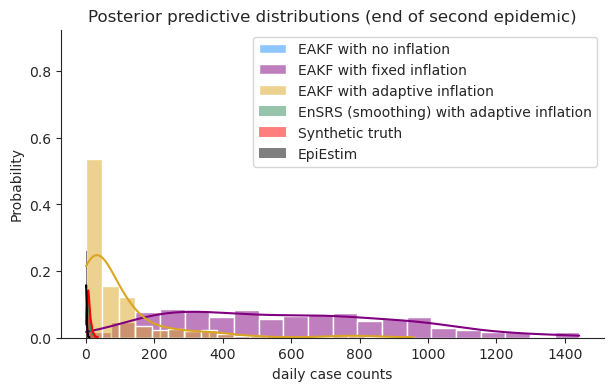

In [43]:
last_epi_day = last_epi_days_df.loc[last_epi_days_df.param == min_rmse_param, "last_epi_day"].values[0]
fig = plot_ppd_hist_at_point(min_rmse_param, last_epi_day, fname="ppd_day")

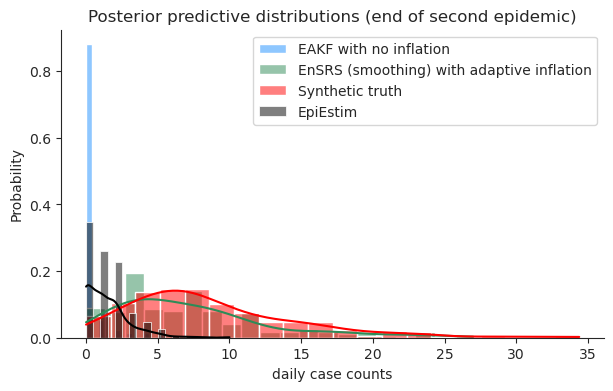

In [44]:
fig = plot_ppd_hist_at_point(min_rmse_param, last_epi_day, fname="ppd_day_subset", plot_good=True)

I have no idea why the fixed inflation posterior predictive distribution SUCKS... Let me rerun this one and double check... for a couple of runs

In [45]:
fixed_pickle_file   = f"{min_rmse_param}_fixed_inflation_run_{0}.pkl"
kf_fixed = get_kf_obj(fixed_pickle_file)
kf_fixed.__dict__.keys()

dict_keys(['f', 'h', 'f0', 'θ0', 'data', 'm', 'SIR', 'ModelParams', 'inf_method', 'xhat_list', 'x_list', 'θ_list', 'lam_list', 'lam_var_list', 'alpha_list', 'i_ppc', 'prop_list', 'beta_prop_list'])

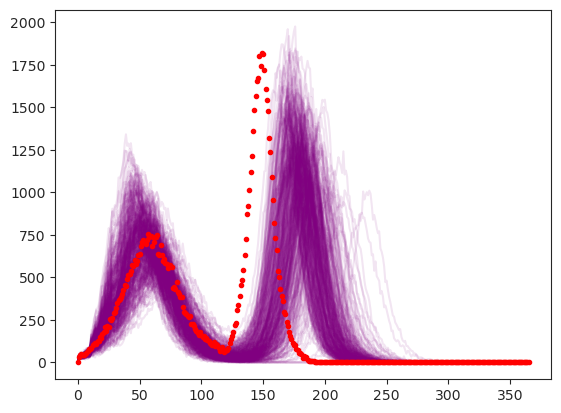

In [46]:
fig, ax = plt.subplots()
ax.plot(kf_fixed.i_ppc, color='purple', alpha=0.1)
ax.plot(kf_fixed.data.i_true, '.', color='red')
plt.show()

It's because of Line 195 in `eakf.py`... I use the true beta up until day 10 when running free simulation... For the other methods it converged fast enough. For the fixed ones it did not converge fast enough.. OOPS

## Double check CRPS for no inflation

It doesn't make sense for the CRPS for the no inflation to be so low after the ensemble has become degenerate.

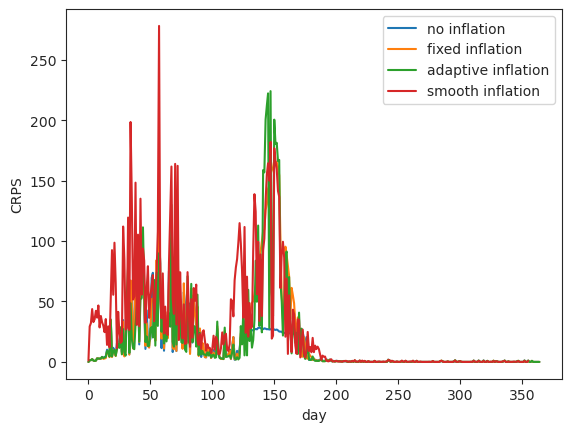

In [47]:
in_dir = "/ifs/scratch/jls106_gp/nhw2114/data/20240806_run_rmse_day"

# get calculated crps time series and plot
df = pd.read_csv(f"{in_dir}/{min_rmse_param}_eakf_metrics.csv").reset_index()
plt.plot(df.loc[df.method == "no inflation", "day"], df.loc[df.method == "no inflation", "crps"], label='no inflation')
plt.plot(df.loc[df.method == "no inflation", "day"], df.loc[df.method == "fixed inflation", "crps"], label='fixed inflation')
plt.plot(df.loc[df.method == "no inflation", "day"], df.loc[df.method == "adaptive inflation", "crps"], label='adaptive inflation')
plt.plot(df.loc[df.method == "smooth inflation", "day"], df.loc[df.method == "smooth inflation", "crps"], label='smooth inflation')

plt.ylabel("CRPS")
plt.xlabel("day")
plt.legend()

In [48]:
wide_df = df.pivot(index='day', columns='method', values='crps').round(4)
wide_df.loc[(wide_df.index <= 150) & (wide_df.index >= 140)]

method,adaptive inflation,fixed inflation,no inflation,smooth inflation
day,,,,
140,24.4807,99.1663,27.9293,38.0093
141,158.7284,108.1037,27.0462,92.2524
142,156.7940,109.6123,27.7972,102.0505
143,200.4358,125.6537,27.5253,133.1466
144,211.8746,130.3623,27.0002,154.7989
145,222.1901,143.1089,27.1882,164.3462
146,28.0757,146.0251,26.7942,150.0596
147,224.0298,155.3237,26.9534,182.0663
148,57.4399,158.6180,27.6462,19.2754


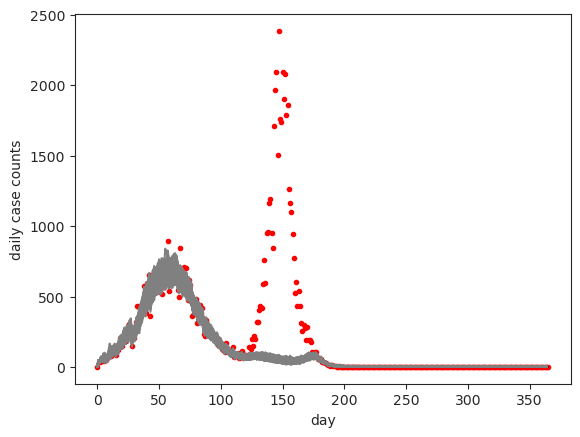

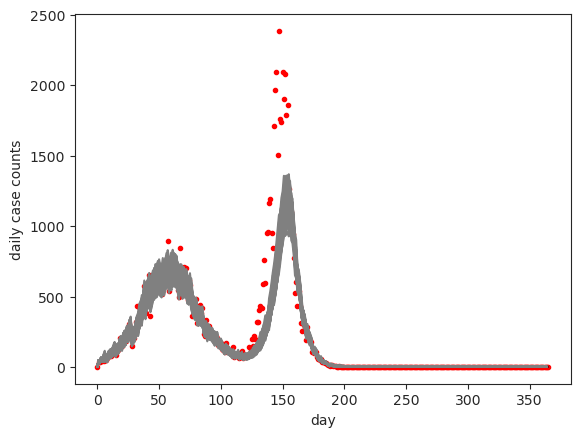

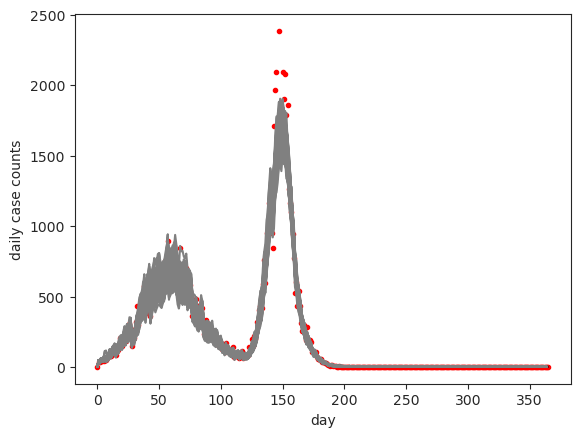

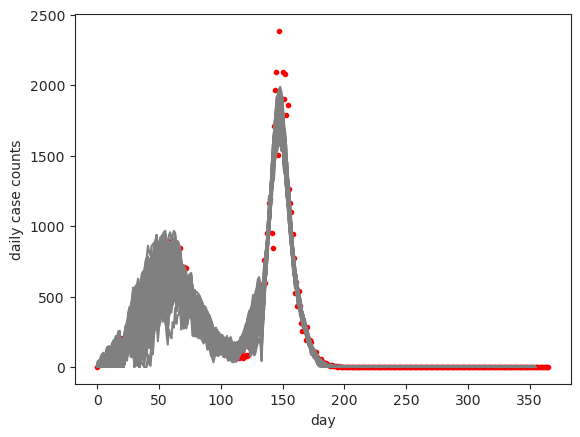

In [49]:
# get kf object and plot posterior
no_pickle_file  = f"{min_rmse_param}_no_inflation_run_0.pkl"
fixed_pickle_file   = f"{min_rmse_param}_fixed_inflation_run_0.pkl"
adapt_pickle_file   = f"{min_rmse_param}_adaptive_inflation_run_0.pkl"
smooth_pickle_file  = f"{min_rmse_param}_smooth_inflation_run_0.pkl"

kf_no = get_kf_obj(no_pickle_file)
kf_fixed = get_kf_obj(fixed_pickle_file)
kf_adapt = get_kf_obj(adapt_pickle_file)
kf_smooth = get_kf_obj(smooth_pickle_file)
kfs = [kf_no, kf_fixed, kf_adapt, kf_smooth]

for kf in kfs:
    ensembles = np.array([x.i for x in kf.x_list])
    observations = kf_no.data.i

    fig, ax = plt.subplots()

    ax.plot(observations, '.', color='red')
    ax.plot(ensembles, color='gray')
    ax.set_ylabel('daily case counts')
    ax.set_xlabel('day')
    


In [51]:
from epyfilter.posterior_checks import crps
import CRPS.CRPS as pscore

for kf in kfs:
    for day in range(len(kf_smooth.x_list)):
        my_crps = crps(kf,day)
        
        ensembles = np.array([x.i for x in kf.x_list])
        if day >= ensembles.shape[0]:
            day = -1
        ensembles = np.sort(ensembles[day,:])
        obs = kf.data.i[day]
        crps_crps, _, _ = pscore(ensembles,obs).compute()
    
    if not np.isclose(my_crps, crps_crps):
        print(day)

In [57]:
obs = 1.5
ensembles = np.sort(np.append(np.arange(10), 1.5))
m = len(ensembles)

cdf_obs = ensembles >= obs
cdf = np.linspace(1/m,1,m)
all_mem = ensembles
delta_fc= np.append(np.diff(all_mem), 0)
my_crps = np.sum(np.array((cdf - cdf_obs) ** 2)*delta_fc)

crps_crps, _, _ = pscore(ensembles,obs).compute()

np.isclose(my_crps, crps_crps)

True

In [58]:
print(my_crps)
print(crps_crps)

1.4462809917355368
1.446280991735537


## Time series of KL and W2

### Plot for one parameter scenario

In [47]:
min_rmse_param

6981

saving to /ifs/scratch/jls106_gp/nhw2114/data/example_plots_for_paper//6981_metric_time_series.eps


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


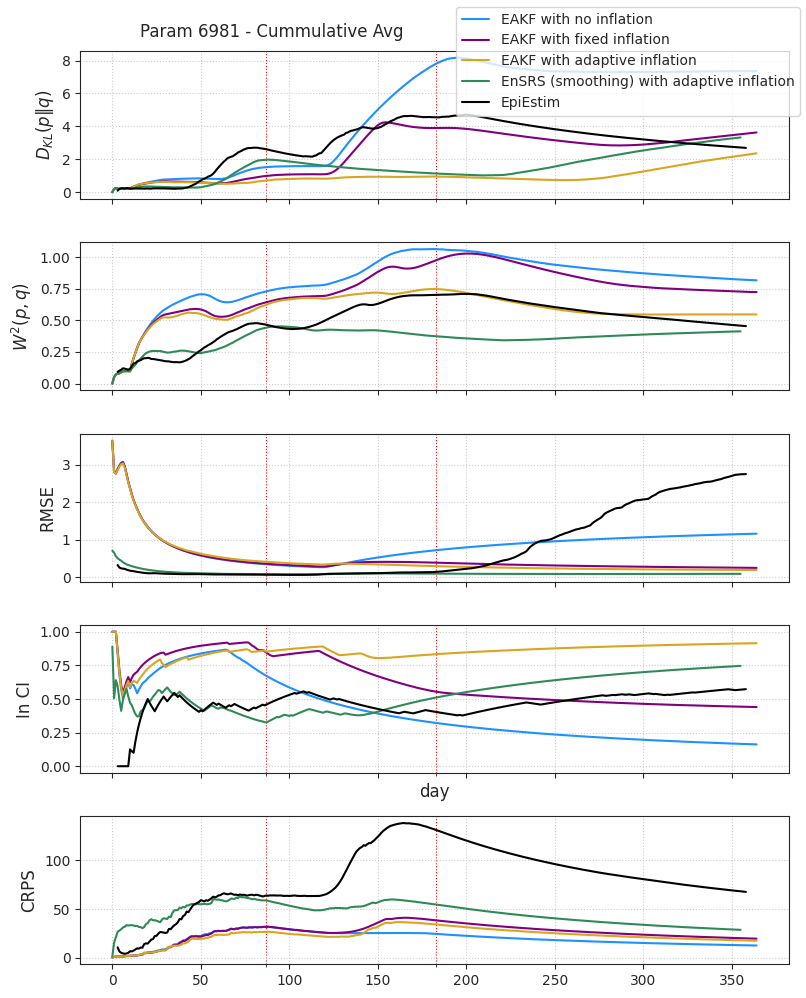

In [49]:
in_dir = "/ifs/scratch/jls106_gp/nhw2114/data/20240727_run_kl_w2_day"
epiestim_in_dir = "/ifs/scratch/jls106_gp/nhw2114/data/20240731_epiestim_run_kl_w2_day"

rmse_in_dir = "/ifs/scratch/jls106_gp/nhw2114/data/20240806_run_rmse_day"
# rmse_epiestim_in_dir = "/ifs/scratch/jls106_gp/nhw2114/data/20240809_epiestim_rmse_crps_reliability_day"
rmse_epiestim_in_dir = "/ifs/scratch/jls106_gp/nhw2114/data/20240813_epiestim_rmse_crps_reliability_day_rerun"


df = pd.read_csv(f"{in_dir}/{min_rmse_param}_eakf_metrics.csv").reset_index()
epiestim_df = pd.read_csv(f"{epiestim_in_dir}/{min_rmse_param}_epiEstim_kl_w2.csv")

rmse_df = pd.read_csv(f"{rmse_in_dir}/{min_rmse_param}_eakf_metrics.csv").reset_index()
rmse_epiestim_df = pd.read_csv(f"{rmse_epiestim_in_dir}/{min_rmse_param}_epiEstim_rmse_crps_reliability.csv")

fig, ax = plt.subplots(5, sharex=True)
fig.set_figheight(10)
fig.set_figwidth(8)

first_day = last_epi_days_df.loc[last_epi_days_df.param == pp, 'first_epi_day'].values[0]
last_day = last_epi_days_df.loc[last_epi_days_df.param == pp, 'last_epi_day'].values[0]

# avg kl
ax[0].plot(df.loc[df.method == "no inflation", "day"], df.loc[df.method == "no inflation", "avg_kl"].expanding().mean(), color="dodgerblue", label=r"EAKF with no inflation")
ax[0].plot(df.loc[df.method == "fixed inflation", "day"], df.loc[df.method == "fixed inflation", "avg_kl"].expanding().mean(), color="purple", label=r"EAKF with fixed inflation")
ax[0].plot(df.loc[df.method == "adaptive inflation", "day"], df.loc[df.method == "adaptive inflation", "avg_kl"].expanding().mean(), color="goldenrod", label=r"EAKF with adaptive inflation")
ax[0].plot(df.loc[df.method == "smooth inflation", "day"], df.loc[df.method == "smooth inflation", "avg_kl"].expanding().mean(), color="seagreen", label=r"EnSRS (smoothing) with adaptive inflation")
ax[0].plot(epiestim_df["day"], epiestim_df["avg_kl"].expanding().mean(), color="black", label=r"EpiEstim")

# avg w2
ax[1].plot(df.loc[df.method == "no inflation", "day"], df.loc[df.method == "no inflation", "avg_w2"].expanding().mean(), color="dodgerblue")
ax[1].plot(df.loc[df.method == "fixed inflation", "day"], df.loc[df.method == "fixed inflation", "avg_w2"].expanding().mean(), color="purple")
ax[1].plot(df.loc[df.method == "adaptive inflation", "day"], df.loc[df.method == "adaptive inflation", "avg_w2"].expanding().mean(), color="goldenrod")
ax[1].plot(df.loc[df.method == "smooth inflation", "day"], df.loc[df.method == "smooth inflation", "avg_w2"].expanding().mean(), color="seagreen")
ax[1].plot(epiestim_df["day"], epiestim_df["avg_w2"].expanding().mean(), color="black")

# avg rmse
ax[2].plot(rmse_df.loc[rmse_df.method == "no inflation", "day"],
           rmse_df.loc[rmse_df.method == "no inflation", "rt_rmse"].expanding().mean(), color="dodgerblue")
ax[2].plot(rmse_df.loc[rmse_df.method == "fixed inflation", "day"],
           rmse_df.loc[rmse_df.method == "fixed inflation", "rt_rmse"].expanding().mean(), color="purple")
ax[2].plot(rmse_df.loc[rmse_df.method == "adaptive inflation", "day"],
           rmse_df.loc[rmse_df.method == "adaptive inflation", "rt_rmse"].expanding().mean(), color="goldenrod")
ax[2].plot(rmse_df.loc[rmse_df.method == "smooth inflation", "day"],
           rmse_df.loc[rmse_df.method == "smooth inflation", "rt_rmse"].expanding().mean(), color="seagreen")
ax[2].plot(rmse_epiestim_df["day"],
           rmse_epiestim_df["rmse"].expanding().mean(), color="black")

# reliability
ax[3].plot(rmse_df.loc[rmse_df.method == "no inflation", "day"],
           rmse_df.loc[rmse_df.method == "no inflation", "in_ci"].expanding().mean(), color="dodgerblue")
ax[3].plot(rmse_df.loc[rmse_df.method == "fixed inflation", "day"],
           rmse_df.loc[rmse_df.method == "fixed inflation", "in_ci"].expanding().mean(), color="purple")
ax[3].plot(rmse_df.loc[rmse_df.method == "adaptive inflation", "day"],
           rmse_df.loc[rmse_df.method == "adaptive inflation", "in_ci"].expanding().mean(), color="goldenrod")
ax[3].plot(rmse_df.loc[rmse_df.method == "smooth inflation", "day"],
           rmse_df.loc[rmse_df.method == "smooth inflation", "in_ci"].expanding().mean(), color="seagreen")
ax[3].plot(rmse_epiestim_df["day"],
           rmse_epiestim_df["in_ci"].expanding().mean(), color="black")

# # crps
ax[4].plot(rmse_df.loc[rmse_df.method == "no inflation", "day"],
           rmse_df.loc[rmse_df.method == "no inflation", "crps"].expanding().mean(), color="dodgerblue")
ax[4].plot(rmse_df.loc[rmse_df.method == "fixed inflation", "day"],
           rmse_df.loc[rmse_df.method == "fixed inflation", "crps"].expanding().mean(), color="purple")
ax[4].plot(rmse_df.loc[rmse_df.method == "adaptive inflation", "day"],
           rmse_df.loc[rmse_df.method == "adaptive inflation", "crps"].expanding().mean(), color="goldenrod")
ax[4].plot(rmse_df.loc[rmse_df.method == "smooth inflation", "day"],
           rmse_df.loc[rmse_df.method == "smooth inflation", "crps"].expanding().mean(), color="seagreen")
ax[4].plot(rmse_epiestim_df["day"],
           rmse_epiestim_df["crps"].expanding().mean(), color="black")

ax[0].set_ylabel(r"$D_{KL}(p \| q)$", fontsize=12)
ax[1].set_ylabel(r"$W^2(p,q)$", fontsize=12)
ax[2].set_ylabel(r"RMSE", fontsize=12)
ax[3].set_ylabel(r"In CI", fontsize=12)
ax[4].set_ylabel(r"CRPS", fontsize=12)

ax[3].set_xlabel("day", fontsize=12)

fig.legend(loc='upper right')
for aa in ax:
    aa.grid(linestyle='dotted')

fig.suptitle(f"Param {min_rmse_param} - Cummulative Avg", horizontalalignment="right")

# add minor ticks for first and last epi day
extraticks = [first_day, last_day]
loc = matplotlib.ticker.FixedLocator(extraticks)
for aa in ax:
    aa.xaxis.set_minor_locator(loc)
    aa.grid(which='minor', color='red', linestyle='dotted')
    
fig.tight_layout()

fname = f"{min_rmse_param}_metric_time_series"
print(f"saving to {plot_dir}/{fname}.eps")
plt.savefig(f"{plot_dir}/{fname}.pdf", bbox_inches='tight', transparent=True)
plt.savefig(f"{plot_dir}/{fname}.eps", format='eps', bbox_inches='tight', transparent=True)

### Plot avg over parameter scenarios

In [50]:
rmse_epiestim_in_dir = "/ifs/scratch/jls106_gp/nhw2114/data/20240813_epiestim_rmse_crps_reliability_day_rerun"

files = glob.glob(f"{rmse_epiestim_in_dir}/*_epiEstim_rmse_crps_reliability.csv")

dataframes = [pd.read_csv(file) for file in files]
mean_epiestim_rmse_df = pd.concat(dataframes)

In [53]:
mean_epiestim_rmse_df = mean_epiestim_rmse_df.groupby("day")[["rmse", "in_ci", "crps"]].mean().reset_index()

In [54]:
mean_epiestim_rmse_df.to_csv(f"{rmse_epiestim_in_dir}/epiEstim_all_rmse_crps_reliability.csv")

In [55]:
mean_kl_w2_df = pd.read_csv(f"{in_dir}/eakf_all_metrics.csv")
mean_epiestim_kl_w2_df = pd.read_csv(f"{epiestim_in_dir}/epiEstim_all_kl_w2.csv")
mean_rmse_dt = pd.read_csv(f"{rmse_in_dir}/eakf_all_metrics.csv")
mean_epiestim_rmse_df = pd.read_csv(f"{rmse_epiestim_in_dir}/epiEstim_all_rmse_crps_reliability.csv")

saving to /ifs/scratch/jls106_gp/nhw2114/data/example_plots_for_paper//avg_metric_time_series.eps


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


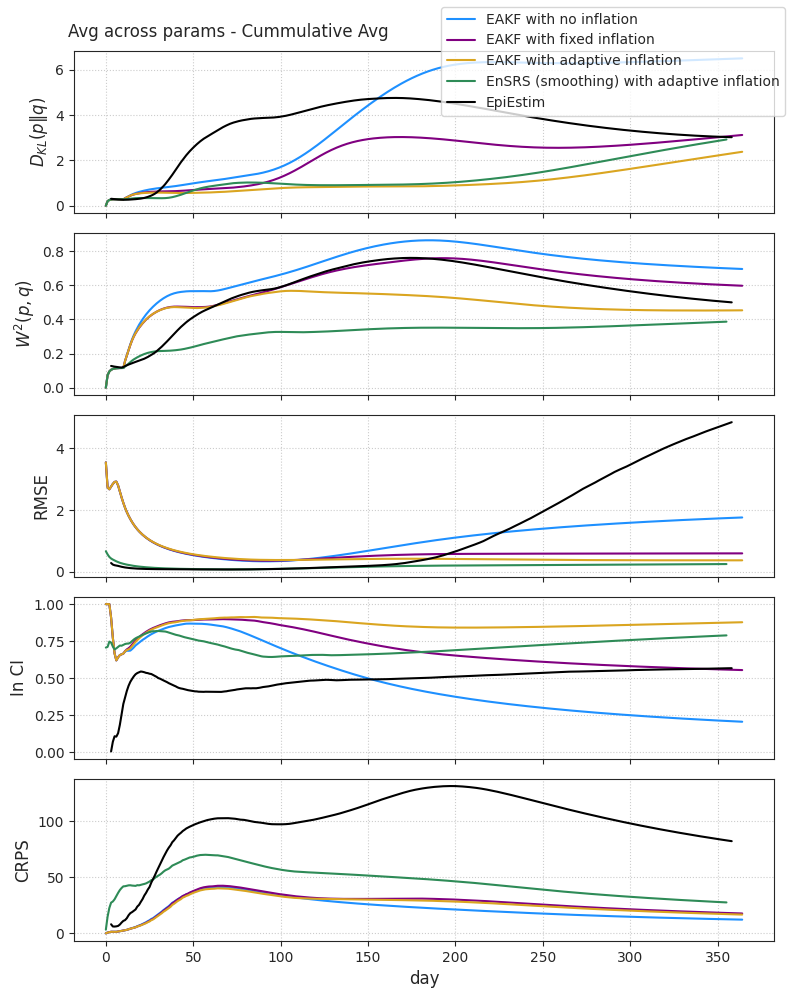

In [56]:
fig, ax = plt.subplots(5, sharex=True)
fig.set_figheight(10)
fig.set_figwidth(8)

ax[0].plot(mean_kl_w2_df.loc[mean_kl_w2_df.method == "no inflation", "day"],
           mean_kl_w2_df.loc[mean_kl_w2_df.method == "no inflation", "avg_kl"].expanding().mean(), color="dodgerblue", label=r"EAKF with no inflation")
ax[0].plot(mean_kl_w2_df.loc[mean_kl_w2_df.method == "fixed inflation", "day"],
           mean_kl_w2_df.loc[mean_kl_w2_df.method == "fixed inflation", "avg_kl"].expanding().mean(), color="purple", label=r"EAKF with fixed inflation")
ax[0].plot(mean_kl_w2_df.loc[mean_kl_w2_df.method == "adaptive inflation", "day"],
           mean_kl_w2_df.loc[mean_kl_w2_df.method == "adaptive inflation", "avg_kl"].expanding().mean(), color="goldenrod", label=r"EAKF with adaptive inflation")
ax[0].plot(mean_kl_w2_df.loc[mean_kl_w2_df.method == "smooth inflation", "day"],
           mean_kl_w2_df.loc[mean_kl_w2_df.method == "smooth inflation", "avg_kl"].expanding().mean(), color="seagreen", label=r"EnSRS (smoothing) with adaptive inflation")
ax[0].plot(mean_epiestim_kl_w2_df["day"],
           mean_epiestim_kl_w2_df["avg_kl"].expanding().mean(), color="black", label=r"EpiEstim")

ax[1].plot(mean_kl_w2_df.loc[mean_kl_w2_df.method == "no inflation", "day"],
           mean_kl_w2_df.loc[mean_kl_w2_df.method == "no inflation", "avg_w2"].expanding().mean(), color="dodgerblue")
ax[1].plot(mean_kl_w2_df.loc[mean_kl_w2_df.method == "fixed inflation", "day"],
           mean_kl_w2_df.loc[mean_kl_w2_df.method == "fixed inflation", "avg_w2"].expanding().mean(), color="purple")
ax[1].plot(mean_kl_w2_df.loc[mean_kl_w2_df.method == "adaptive inflation", "day"],
           mean_kl_w2_df.loc[mean_kl_w2_df.method == "adaptive inflation", "avg_w2"].expanding().mean(), color="goldenrod")
ax[1].plot(mean_kl_w2_df.loc[mean_kl_w2_df.method == "smooth inflation", "day"],
           mean_kl_w2_df.loc[mean_kl_w2_df.method == "smooth inflation", "avg_w2"].expanding().mean(), color="seagreen")
ax[1].plot(mean_epiestim_kl_w2_df["day"],
           mean_epiestim_kl_w2_df["avg_w2"].expanding().mean(), color="black")

ax[2].plot(mean_rmse_dt.loc[mean_rmse_dt.method == "no inflation", "day"],
           mean_rmse_dt.loc[mean_rmse_dt.method == "no inflation", "rt_rmse"].expanding().mean(), color="dodgerblue")
ax[2].plot(mean_rmse_dt.loc[mean_rmse_dt.method == "fixed inflation", "day"],
           mean_rmse_dt.loc[mean_rmse_dt.method == "fixed inflation", "rt_rmse"].expanding().mean(), color="purple")
ax[2].plot(mean_rmse_dt.loc[mean_rmse_dt.method == "adaptive inflation", "day"],
           mean_rmse_dt.loc[mean_rmse_dt.method == "adaptive inflation", "rt_rmse"].expanding().mean(), color="goldenrod")
ax[2].plot(mean_rmse_dt.loc[mean_rmse_dt.method == "smooth inflation", "day"],
           mean_rmse_dt.loc[mean_rmse_dt.method == "smooth inflation", "rt_rmse"].expanding().mean(), color="seagreen")
ax[2].plot(mean_epiestim_rmse_df["day"],
           mean_epiestim_rmse_df["rmse"].expanding().mean(), color="black")

ax[3].plot(mean_rmse_dt.loc[mean_rmse_dt.method == "no inflation", "day"],
           mean_rmse_dt.loc[mean_rmse_dt.method == "no inflation", "in_ci"].expanding().mean(), color="dodgerblue")
ax[3].plot(mean_rmse_dt.loc[mean_rmse_dt.method == "fixed inflation", "day"],
           mean_rmse_dt.loc[mean_rmse_dt.method == "fixed inflation", "in_ci"].expanding().mean(), color="purple")
ax[3].plot(mean_rmse_dt.loc[mean_rmse_dt.method == "adaptive inflation", "day"],
           mean_rmse_dt.loc[mean_rmse_dt.method == "adaptive inflation", "in_ci"].expanding().mean(), color="goldenrod")
ax[3].plot(mean_rmse_dt.loc[mean_rmse_dt.method == "smooth inflation", "day"],
           mean_rmse_dt.loc[mean_rmse_dt.method == "smooth inflation", "in_ci"].expanding().mean(), color="seagreen")
ax[3].plot(mean_epiestim_rmse_df["day"],
           mean_epiestim_rmse_df["in_ci"].expanding().mean(), color="black")

ax[4].plot(mean_rmse_dt.loc[mean_rmse_dt.method == "no inflation", "day"],
           mean_rmse_dt.loc[mean_rmse_dt.method == "no inflation", "crps"].expanding().mean(), color="dodgerblue")
ax[4].plot(mean_rmse_dt.loc[mean_rmse_dt.method == "fixed inflation", "day"],
           mean_rmse_dt.loc[mean_rmse_dt.method == "fixed inflation", "crps"].expanding().mean(), color="purple")
ax[4].plot(mean_rmse_dt.loc[mean_rmse_dt.method == "adaptive inflation", "day"],
           mean_rmse_dt.loc[mean_rmse_dt.method == "adaptive inflation", "crps"].expanding().mean(), color="goldenrod")
ax[4].plot(mean_rmse_dt.loc[mean_rmse_dt.method == "smooth inflation", "day"],
           mean_rmse_dt.loc[mean_rmse_dt.method == "smooth inflation", "crps"].expanding().mean(), color="seagreen")
ax[4].plot(mean_epiestim_rmse_df["day"],
           mean_epiestim_rmse_df["crps"].expanding().mean(), color="black")

ax[0].set_ylabel(r"$D_{KL}(p \| q)$", fontsize=12)
ax[1].set_ylabel(r"$W^2(p,q)$", fontsize=12)
ax[2].set_ylabel(r"RMSE", fontsize=12)
ax[3].set_ylabel(r"In CI", fontsize=12)
ax[4].set_ylabel(r"CRPS", fontsize=12)

ax[4].set_xlabel("day", fontsize=12)

fig.legend(loc='upper right')
for a in ax:
    a.grid(linestyle='dotted')

fig.suptitle("Avg across params - Cummulative Avg", horizontalalignment="right")
fig.tight_layout()

fname="avg_metric_time_series"
print(f"saving to {plot_dir}/{fname}.eps")
plt.savefig(f"{plot_dir}/{fname}.pdf", bbox_inches='tight', transparent=True)
plt.savefig(f"{plot_dir}/{fname}.eps", format='eps', bbox_inches='tight', transparent=True)

# Compute correlations with params

In [ ]:
param_df = pd.read_csv("param_list.csv")
param_df["param"] = param_df.index

In [ ]:
param_df['early_day'] = -1/param_df.k * np.log((param_df.rt_1 - param_df.rt_0)/(1.01*param_df.rt_0 - param_df.rt_0)-1) + param_df.midpoint
param_df['late_day'] = -1/param_df.k * np.log((param_df.rt_1 - param_df.rt_0)/(0.99*param_df.rt_1 - param_df.rt_0)-1) + param_df.midpoint
param_df['day_diff'] = param_df['late_day'] - param_df['early_day']
param_df['rt_diff'] = param_df['rt_1'] - param_df['rt_0']

In [ ]:
merge_df = merge_df.merge(param_df, on="param")
epiestim_metrics_df = epiestim_metrics_df.merge(param_df, on="param")

In [ ]:
metric_cols = ['rt_peak_rmse', 'rt_rmse', 'rt_last_epi_day_rmse',
       'data_rmse', 'data_rmse_last_epi_day', 'avg_w2', 'avg_kl', 'in_ci',
       'ens_var', 'in_ci_last_day', 'ens_var_last_day', 'in_ci_last_epi_day',
       'ens_var_last_epi_day', 'avg_w2_last_epi_day', 'avg_kl_last_epi_day']
param_cols = ['rt_0', 'rt_1', 'midpoint', 'k', 'early_day', 'late_day', 'day_diff', 'rt_diff']

In [ ]:
from sklearn.manifold import TSNE
X = param_df.loc[param_df.param.isin(merge_df.param), ['rt_0', 'rt_1', 'midpoint', 'k']]
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

# Plot the t-SNE results
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1])

# Add legends and labels
plt.title('t-SNE Plot of Parameters for Synthetic Data')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

# Show the plot
plt.show()

In [ ]:
import seaborn as sns

correlation_matrix = merge_df[metric_cols + param_cols].corr()
correlation_matrix_subset = correlation_matrix.loc[correlation_matrix.index.isin(param_cols),metric_cols]

# Create a heatmap
plt.figure(figsize=(18, 6))
sns.heatmap(correlation_matrix_subset, annot=True, cmap='coolwarm', linewidths=.5, square=True)

# Customize the plot
plt.title('Correlation Heatmap')
plt.show()

correlation_matrix_subset.to_csv("correlation.csv", index=False)

In [ ]:
# move files
# files = glob.glob(dir + '/*epiEsim_plots.pdf')

# new_dir = "/ifs/scratch/jls106_gp/nhw2114/data/20231106_synthetic_data/pdf_archive/"
# for f in tqdm(files):
#     new_path = new_dir + os.path.basename(f)
#     os.rename(f, new_path)


In [ ]:
merge_df

In [ ]:
import seaborn as sns

_methods = ['adaptive inflation', 'fixed inflation', 'no inflation', 'smooth']
sns.relplot(data=eakf_metrics_df, x='in_ci_last_day', y='ens_var_last_day', hue='method', hue_order=_methods, aspect=1.61)
plt.show()

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
no_ci = merge_df.loc[merge_df["method"] == "no inflation", "in_ci_last_day"]
fix_ci = merge_df.loc[merge_df["method"] == "fixed inflation", "in_ci_last_day"]
adapt_ci = merge_df.loc[merge_df["method"] == "adaptive inflation", "in_ci_last_epi_day"]
smooth_ci = merge_df.loc[merge_df["method"] == "smooth", "in_ci_last_day"]
# ax.hist(no_ci, bins=20, color='green', label="no inflation", edgecolor='black', alpha=0.25, density=True, range=[0.0, 1.0])
# ax.hist(fix_ci, bins=20, color='orange', label="fixed inflation", edgecolor='black', alpha=0.25, density=True)
ax.hist(adapt_ci, bins=20, color='blue', label="adaptive inflation", edgecolor='black', alpha=0.25, density=True) 
# ax.hist(smooth_ci, bins=20, color='red', label="smoothing", edgecolor='black', alpha=0.25, density=True) 

ax.yaxis.set_major_formatter(PercentFormatter(xmax=100))
plt.xlabel('Proportion of runs in 95% CI')
plt.ylabel('Frequency')
plt.legend()

In [ ]:
# fig = plt.figure()
# ax = fig.add_subplot(111)
# no_ci = eakf_metrics_df.loc[eakf_metrics_df["method"] == "no inflation", "ens_var_last_day"]
# # fix_ci = eakf_metrics_df.loc[eakf_metrics_df["method"] == "fixed inflation", "ens_var_last_day"]
# adapt_ci = eakf_metrics_df.loc[eakf_metrics_df["method"] == "adaptive inflation", "ens_var_last_day"]
# smooth_ci = eakf_metrics_df.loc[eakf_metrics_df["method"] == "smooth", "ens_var_last_day"]

# # ax.hist(no_ci, bins=5, color='green', label="no inflation", edgecolor='black', alpha=0.25, density=True, range=[0.0, 1.0])
# ax.hist(fix_ci, bins=5, color='orange', label="fixed inflation", edgecolor='black', alpha=0.25, density=True)
# ax.hist(adapt_ci, bins=5, color='blue', label="adaptive inflation", edgecolor='black', alpha=0.25, density=True) 
# ax.hist(smooth_ci, bins=5, color='red', label="smoothing", edgecolor='black', alpha=0.25, density=True) 

# # ax.yaxis.set_major_formatter(PercentFormatter(xmax=100))
# plt.title('Histogram Example')
# plt.xlabel('Ensemble Variance')
# plt.ylabel('Frequency')
# plt.legend()

In [ ]:
# from scipy.stats.kde import gaussian_kde

# x = eakf_metrics_df.loc[eakf_metrics_df["method"] == "adaptive inflation", "in_ci_last_day"]
# y = eakf_metrics_df.loc[eakf_metrics_df["method"] == "adaptive inflation", "ens_var_last_day"]
# Z, xedges, yedges = np.histogram2d(x, y,bins=5)
# plt.pcolormesh(xedges, yedges, Z.T)
# plt.colorbar()



# Compute last day

In [ ]:
import glob
import pandas as pd
import os
import numpy as np
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

import pickle
from epyfilter import simulate_data

from scipy.signal import argrelmin

from epyfilter.compute_days import compute_last_epi_day, compute_first_epi_day, compute_peaks
from matplotlib.backends.backend_pdf import PdfPages


good_param_df = pd.read_csv("good_param_list.csv")
pickle_list = [f"/ifs/scratch/jls106_gp/nhw2114/data/20231025_synthetic_data/{param}_synthetic_data.pkl" for param in good_param_df.param]

def open_pickle(pickle_file):
    with open(pickle_file, 'rb') as file:
        data = pickle.load(file)
    return data

last_day_array = np.empty(shape=(len(pickle_list), 2))

In [ ]:
sample_params = good_param_df.sample(100).param.tolist()

In [ ]:
for i in range(len(sample_params)):
    pp = sample_params[i]
    data = open_pickle(f"/ifs/scratch/jls106_gp/nhw2114/data/20231025_synthetic_data/{pp}_synthetic_data.pkl")

    zero_days = np.where(data.i_true == 0)
    last_epi_day = compute_last_epi_day(data)
    first_epi_day = compute_first_epi_day(data)

    fig, ax = plt.subplots()
    ax.plot(data.i_true, '.', label='i_true')
    ax.vlines(first_epi_day, 0, max(data.i), color='orange', label='first_epi_day')
    ax.vlines(last_epi_day, 0, max(data.i), color='red', label='last_epi_day')
    ax.grid(linestyle='dotted')
    ax.legend()
    ax.set_title(pp)


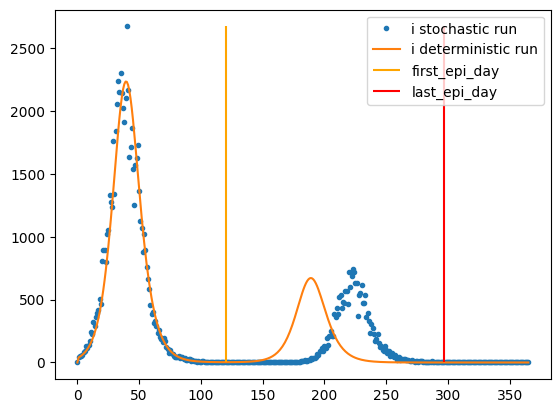

In [7]:
pp = 89430
data = open_pickle(f"/ifs/scratch/jls106_gp/nhw2114/data/20231025_synthetic_data/{pp}_synthetic_data.pkl")
first_epi_day = compute_first_epi_day(data)
last_epi_day = compute_last_epi_day(data)
det_data = simulate_data.simulate_data(**data.true_params, run_deterministic=True)

fig, ax = plt.subplots()
# ax.plot(data.i_true, '.', label='i_true')
ax.plot(data.i, '.', label='i stochastic run')
ax.plot(det_data.i, '-', label='i deterministic run')
ax.vlines(first_epi_day, 0, max(data.i), color='orange', label='first_epi_day')
ax.vlines(last_epi_day, 0, max(data.i), color='red', label='last_epi_day')
ax.legend()

# Fix last epi day

In [22]:
last_day_df = pd.read_csv("/ifs/scratch/jls106_gp/nhw2114/repos/rt-estimation/src/epyfilter/c2b2/last_epidemic_day.csv")

In [44]:
to_do_params = []
last_epi_days = []

for index, row in tqdm(last_day_df.iterrows()):
    param = row['param']
    last_epi_day = row['last_epidemic_day']
    pp = f"/ifs/scratch/jls106_gp/nhw2114/data/20231025_synthetic_data/{param}_synthetic_data.pkl"
    data = open_pickle(pp)
    zero_days = np.where(data.i_true == 0)[0]
    if len(zero_days) == 1:  # never reached 0
        last_day = len(data.i_true)
    else:
        first_zero_day = zero_days[1]
        non_zero_days = np.where(data.i_true > 10)[0]
        if np.any(non_zero_days > first_zero_day):
            last_days = zero_days[zero_days > np.max(non_zero_days)]
            if len(last_days) == 0:
                last_day = len(data.i_true)
            else:
                last_day = last_days[0]
        else:
            last_day = first_zero_day
    if last_epi_day != last_day:
        to_do_params.append(param)
        last_epi_days.append(last_day)
        

47871it [1:23:21,  9.57it/s]


In [57]:
pd.DataFrame(np.array((to_do_params, last_epi_days)).T, columns=["param", "last_epi_day"]).to_csv("to_do_params_last_epi_day.csv", index=False)

In [38]:
# for param in to_do_params[0:10]:
#     pp = f"/ifs/scratch/jls106_gp/nhw2114/data/20231025_synthetic_data/{param}_synthetic_data.pkl"
#     data = open_pickle(pp)
#     last_epi_day = last_day_df.loc[last_day_df.param == param, 'last_epidemic_day'].values[0]
#     plt.plot(data.i_true, '.')
#     plt.axvline(x = last_epi_day)

array([  0, 162, 173, 174, 175, 176, 177, 179, 182, 184, 186])

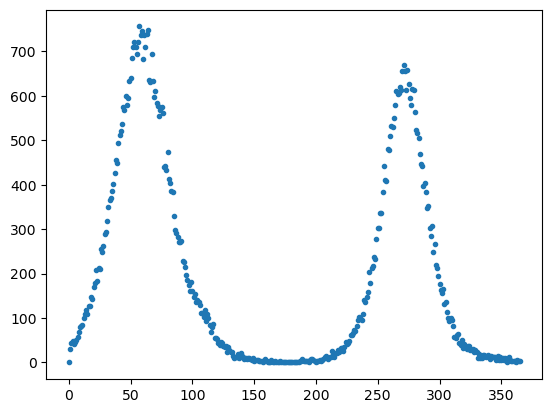

In [29]:
plt.plot(data.i_true, '.')
np.where(data.i_true == 0)[0]

# COMPUTE LAST DAY, PEAKS, DATA DISTRIBUTION, AND 

In [22]:
import pickle
from epyfilter import simulate_data
from tqdm import tqdm

# good_param_df = pd.read_csv("good_param_list.csv")
# pickle_list = [f"/ifs/scratch/jls106_gp/nhw2114/data/20231025_synthetic_data/{param}_synthetic_data.pkl" for param in good_param_df.param]

def compute_late_day(data):
    beta_1 = data.rt_1 / data.t_I
    beta_0 = data.rt_0 / data.t_I
    late_day = -1/data.k * np.log((beta_1 - beta_0)/(0.99*beta_1 - beta_0)-1) + data.midpoint
    late_day = int(late_day)
    return late_day

def compute_peaks(data):
    det_data = simulate_data.simulate_data(**data.true_params, run_deterministic=True)
    peak_days, = np.where(np.diff(np.sign(np.diff(det_data.i_true))) == -2)  # days where it increases before then decreases
    peak_days = peak_days[:2]  # just take first two days
    return peak_days

def open_pickle(pickle_file):
    with open(pickle_file, 'rb') as file:
        data = pickle.load(file)
    return data

In [27]:
# data_files = glob.glob(dir + '/*_data_distribution.csv')
# done_params = [int(os.path.basename(f).split("_")[0]) for f in data_files]
# todo_params = list(set(good_param_df.param) - set(done_params))

# pickle_list = [f"/ifs/scratch/jls106_gp/nhw2114/data/20231025_synthetic_data/{param}_synthetic_data.pkl" for param in todo_params]

In [28]:
# pickle_list = [f"/ifs/scratch/jls106_gp/nhw2114/data/example_plots_for_paper/{param}_synthetic_data.pkl" for param in params]

In [24]:
pickle_list = [f"/ifs/scratch/jls106_gp/nhw2114/data/example_plots_for_paper/{param}_synthetic_data.pkl" for param in to_do_params]

In [25]:
for pp in tqdm(pickle_list):
    param = os.path.basename(pp).split("_")[0]
    data = open_pickle(pp)
    data_distribution_df = pd.DataFrame(data.data_distribution, columns=[f"sample{x}" for x in range(1,301)])
    data_distribution_df["day"] = range(len(data_distribution_df))
    data_distribution_df["late_day"] = compute_late_day(data)
    peaks = compute_peaks(data)
    data_distribution_df["peak1"] = peaks[0]
    data_distribution_df["peak2"] = peaks[1]
    
    data_distribution_df.to_csv(f"/ifs/scratch/jls106_gp/nhw2114/data/example_plots_for_paper/{param}_data_distribution.csv", index=False)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.48it/s]


In [26]:
len(glob.glob('/ifs/scratch/jls106_gp/nhw2114/data/example_plots_for_paper/' + '/*_data_distribution.csv'))

52

# Fix Single Epidemics

In [7]:
pickles = glob.glob(dir + '/*.pkl')

In [8]:
import pickle
def open_pickle(pickle_file):
    with open(pickle_file, 'rb') as file:
        data = pickle.load(file)
    return data

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100185/100185 [3:04:18<00:00,  9.06it/s]


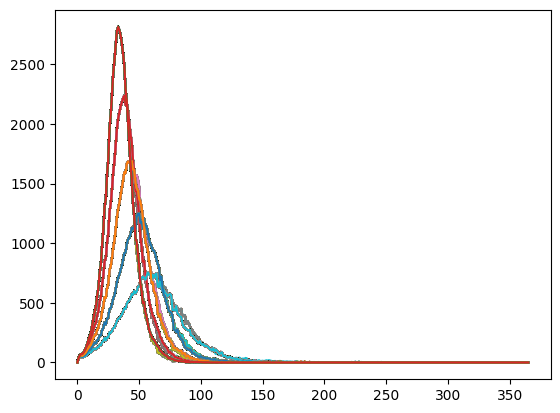

In [10]:
from tqdm import tqdm
from scipy.signal import find_peaks

bad_params = []
for file in tqdm(pickles):
    data = open_pickle(file)

    window_size = 10  # Adjust this window size as needed
    smoothed_data = np.convolve(data.i_true, np.ones(window_size) / window_size, mode='valid')
    peaks, _ = find_peaks(smoothed_data, height=100, prominence=10)
    if len(peaks) < 2:
        bad_params.append(file)
        plt.plot(data.i_true)

In [11]:
len(bad_params)

52314

In [14]:
pd.DataFrame(bad_params).to_csv("one_epidemic_curve.csv", index=False)

In [18]:
bad_metric_files = [f"/ifs/scratch/jls106_gp/nhw2114/data/20231025_synthetic_data/{os.path.basename(b).split('_')[0]}_eakf_metrics.csv" for b in bad_params]

In [21]:
dfs = []
for file in tqdm(files):
    if file not in bad_metric_files:
        df = pd.read_csv(file)
        param = os.path.basename(file).split("_")[0]
        df["param"] = param
        dfs.append(df)

good_combined_df = pd.concat(dfs, ignore_index=False)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100185/100185 [07:22<00:00, 226.36it/s]


In [22]:
good_combined_df[["method", "rt_peak_rmse", "rt_rmse", "data_rmse", "avg_w2", "avg_kl", "in_ci"]].groupby("method").mean()

,rt_peak_rmse,rt_rmse,data_rmse,avg_w2,avg_kl,in_ci
method,,,,,,
adaptive inflation,0.084815,0.374231,47.154245,0.642203,0.952536,0.662593
fixed inflation,0.044096,0.599377,68.936821,0.811197,3.306851,0.172927
no inflation,0.024710,1.763012,117.320087,0.988873,7.159461,0.000000
smooth,0.043557,0.253248,58.496632,0.383990,0.968416,0.543410


Text(0, 0.5, 'Count')

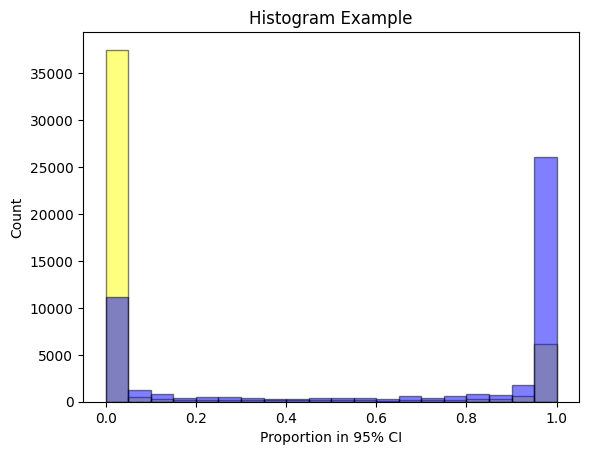

In [23]:
plt.hist(good_combined_df.loc[good_combined_df["method"] == "fixed inflation", "in_ci"], bins=20, color='yellow', edgecolor='black', alpha=0.5)
plt.hist(good_combined_df.loc[good_combined_df["method"] == "adaptive inflation", "in_ci"], bins=20, color='blue', edgecolor='black', alpha=0.5)
plt.title('Histogram Example')
plt.xlabel('Proportion in 95% CI')
plt.ylabel('Count')

In [42]:
pd.DataFrame(good_combined_df.param.unique(), columns=["param"]).to_csv("good_param_list.csv", index=False)

In [45]:
df = pd.read_csv("good_param_list.csv")
pickle_files = df.iloc[1:1000, 0]

In [46]:
pickle_files = [f"/ifs/scratch/jls106_gp/nhw2114/data/20231025_synthetic_data/{p}_synthetic_data.pkl" for p in pickle_files]

In [51]:
4788/200 * 3

71.82000000000001

In [55]:
files = glob.glob(dir + '/*_for_epiestim.csv')

In [58]:
pd.read_csv(files[0])

,rt,i,prop_S
0,1.3,33.742320,0.99869
1,1.3,42.500996,0.99826
2,1.3,45.972273,0.99778
3,1.3,38.297496,0.99736
4,1.3,38.854358,0.99690
...,...,...,...
360,4.7,0.000000,0.58860
361,4.7,0.396479,0.58860
362,4.7,0.000000,0.58860
363,4.7,0.000000,0.58860
